In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_root = "/content/drive/MyDrive/Colab Notebooks/supermarket transactional data/synthetic_woolworths_cleaned.csv"

import pandas as pd

df = pd.read_csv(data_root)

df_original = pd.read_csv(data_root)

# Show column names and data types
print("Col Names and Data Types:")
print(df.dtypes)

# Show basic statistical summary
print("\nBasic Stats:")
print(df.describe(include='all'))

Mounted at /content/drive
Col Names and Data Types:
Transaction ID      object
Purchase Date       object
Store Name          object
Location            object
Customer ID         object
Gender              object
Item ID             object
Brand               object
Item Name           object
Category            object
Product Code         int64
Best Price         float64
Unit Price         float64
Discount Amount    float64
Quantity             int64
Total              float64
Payment Type        object
dtype: object

Basic Stats:
         Transaction ID Purchase Date Store Name Location      Customer ID  \
count            120222        120222     120222   120222           120222   
unique           120222           213          2        8           120222   
top     WOOL-0AF9E2BF71    2024-08-26      Metro   Hobart  WOOL-B0FB99EADD   
freq                  1           623      60244    15114                1   
mean                NaN           NaN        NaN      NaN              

In [ ]:
# 1. List all columns
print("Dataset columns:")
for col in df.columns:
    print(f"- {col}")

# 2. Parse the purchase date
df['PurchaseDate'] = pd.to_datetime(df['Purchase Date'])

# 3. Enrich with time-based features
df['WeekOfYear'] = df['PurchaseDate'].dt.isocalendar().week
df['Fortnight']   = ((df['WeekOfYear'] - 1) // 2) + 1
df['Month']       = df['PurchaseDate'].dt.month
df['Quarter']     = df['PurchaseDate'].dt.quarter
df['DayOfWeek']   = df['PurchaseDate'].dt.day_name()

# 4. Compute BasketSize (total quantity per transaction)
df['BasketSize'] = df.groupby('Transaction ID')['Quantity'].transform('sum')

# 5. Peek at the enriched data
columns_to_show = [
    'Transaction ID', 'Purchase Date', 'Quantity', 'Total',
    'WeekOfYear', 'Fortnight', 'Month', 'Quarter', 'DayOfWeek', 'BasketSize'
]
df[columns_to_show].head()


Dataset columns:
- Transaction ID
- Purchase Date
- Store Name
- Location
- Customer ID
- Gender
- Item ID
- Brand
- Item Name
- Category
- Product Code
- Best Price
- Unit Price
- Discount Amount
- Quantity
- Total
- Payment Type


Transaction ID Purchase Date  Quantity  Total  WeekOfYear  Fortnight  \
0  WOOL-C57727A12D    2025-03-02         6   4.86           9          5   
1  WOOL-3DAA220567    2024-11-10         2   1.30          45         23   
2  WOOL-6E24CDF252    2024-12-23         1   0.86          52         26   
3  WOOL-6406557334    2024-08-25        10  23.00          34         17   
4  WOOL-7D545C83DD    2024-09-05         1   2.20          36         18   

   Month  Quarter DayOfWeek  BasketSize  
0      3        1    Sunday           6  
1     11        4    Sunday           2  
2     12        4    Monday           1  
3      8        3    Sunday          10  
4      9        3  Thursday           1


Summary Statistics of TransactionValue & BasketSize:


statistic  TransactionValue  BasketSize
0      mean         62.275008    5.491457
1    median         33.000000    5.000000
2       min          0.420000    1.000000
3       max       2916.000000   10.000000


Unique Products per Category:


Category  UniqueProducts
0                    Bakery            2373
1    Beauty & Personal Care           17334
2      Beer, Wine & Spirits            8860
3    Cleaning & Maintenance           10306
4      Dairy, Eggs & Fridge            8066
5      Deli & Chilled Meals            4662
6                    Drinks            8082
7               Electronics            1267
8                   Freezer            5951
9               Fruit & Veg            1938
10         Home & Lifestyle            8825
11      International Foods            4849
12                   Pantry           26430
13  Poultry, Meat & Seafood            2634
14   Snacks & Confectionery            8645


Transactions per Store:


Store Name  TransactionCount
0       Metro             60244
1  Woolworths             59978

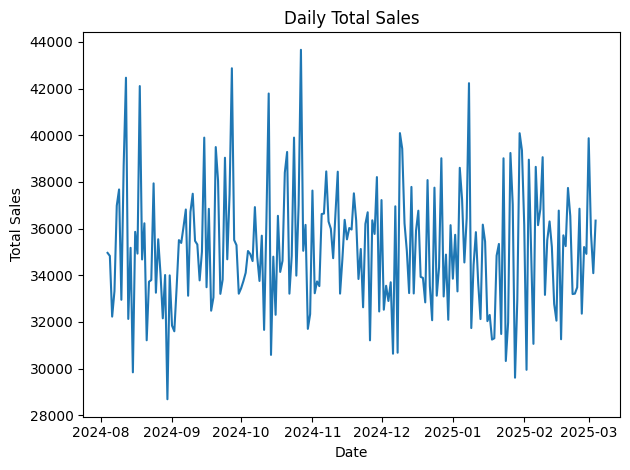

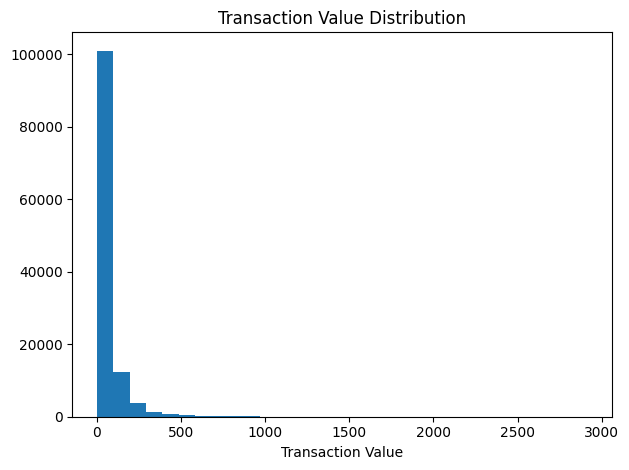

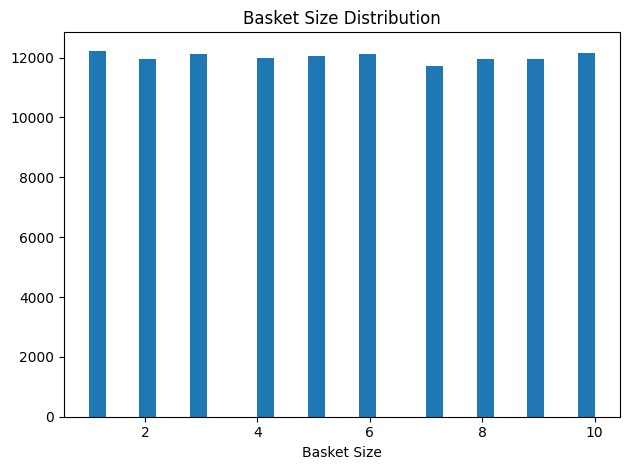

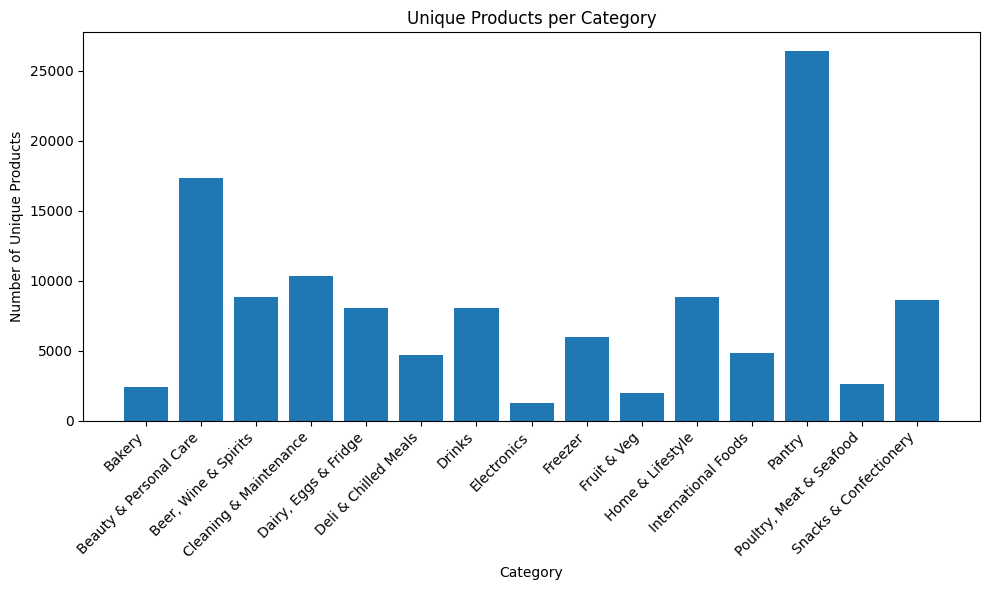

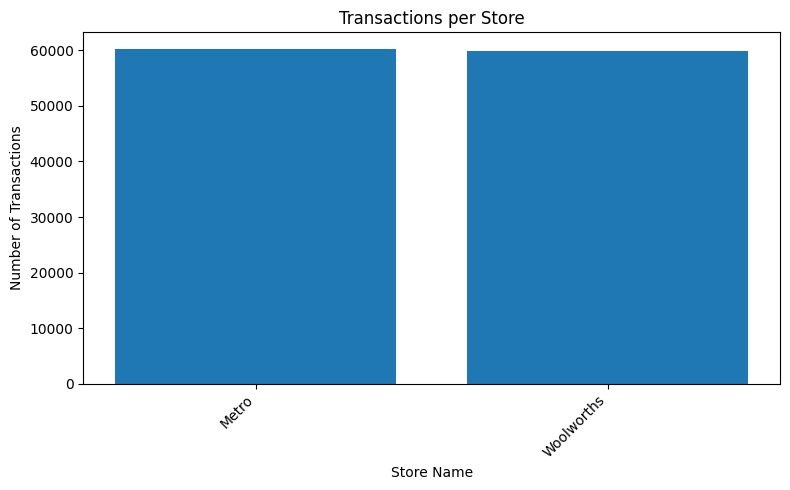

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 2. Parse dates & derive fields
df['PurchaseDate'] = pd.to_datetime(df['Purchase Date'])
df['TransactionValue'] = df['Total']
df['BasketSize'] = df.groupby('Transaction ID')['Quantity'].transform('sum')

# 3. Prepare daily series for STL
df_daily = df.set_index('PurchaseDate').resample('D')['TransactionValue'].sum().asfreq('D', fill_value=0).reset_index()

# 4. Basic summaries
summary_stats = pd.DataFrame({
    'statistic': ['mean', 'median', 'min', 'max'],
    'TransactionValue': [
        df['TransactionValue'].mean(),
        df['TransactionValue'].median(),
        df['TransactionValue'].min(),
        df['TransactionValue'].max()
    ],
    'BasketSize': [
        df['BasketSize'].mean(),
        df['BasketSize'].median(),
        df['BasketSize'].min(),
        df['BasketSize'].max()
    ]
})
print("\nSummary Statistics of TransactionValue & BasketSize:")
display(summary_stats)

# 5. Categorical counts
products_per_category = (
    df.groupby('Category')['Item ID']
      .nunique()
      .reset_index()
      .rename(columns={'Item ID': 'UniqueProducts'})
)
transactions_per_store = (
    df.groupby('Store Name')['Transaction ID']
      .nunique()
      .reset_index()
      .rename(columns={'Transaction ID': 'TransactionCount'})
)
print("\nUnique Products per Category:")
display(products_per_category)
print("\nTransactions per Store:")
display(transactions_per_store)

# 6. Plots
plt.figure()
plt.plot(df_daily['PurchaseDate'], df_daily['TransactionValue'])
plt.title('Daily Total Sales')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df['TransactionValue'], bins=30)
plt.title('Transaction Value Distribution')
plt.xlabel('Transaction Value')
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(df['BasketSize'], bins=30)
plt.title('Basket Size Distribution')
plt.xlabel('Basket Size')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(products_per_category['Category'], products_per_category['UniqueProducts'])
plt.title('Unique Products per Category')
plt.xlabel('Category')
plt.ylabel('Number of Unique Products')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(transactions_per_store['Store Name'], transactions_per_store['TransactionCount'])
plt.title('Transactions per Store')
plt.xlabel('Store Name')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


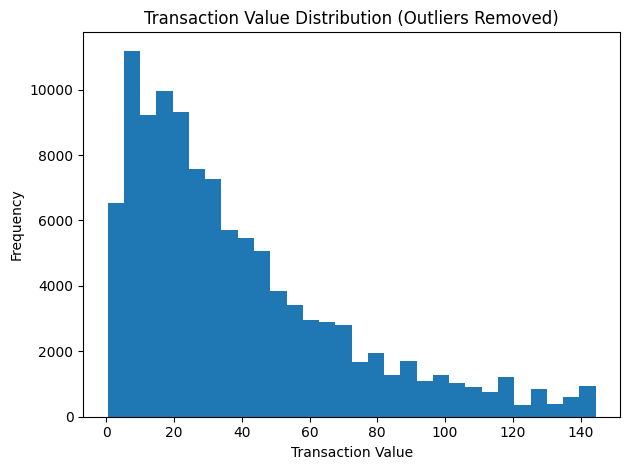

In [ ]:
# 2. Compute transaction-level sums
transaction_totals = df.groupby('Transaction ID')['Total'].sum().reset_index(name='TransactionSum')

# 3. Calculate IQR bounds
Q1 = transaction_totals['TransactionSum'].quantile(0.25)
Q3 = transaction_totals['TransactionSum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Filter out outlier transactions
clean_totals = transaction_totals[
    (transaction_totals['TransactionSum'] >= lower_bound) &
    (transaction_totals['TransactionSum'] <= upper_bound)
]

# 5. Plot histogram of cleaned transaction values
plt.figure()
plt.hist(clean_totals['TransactionSum'], bins=30)
plt.title('Transaction Value Distribution (Outliers Removed)')
plt.xlabel('Transaction Value')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Skewness & Kurtosis:


Metric     Value
0  Skewness  1.234366
1  Kurtosis  0.974849

Key Quantiles:


Quantile  TransactionValue
0      0.25              15.0
1      0.50              30.0
2      0.75              54.0
3      0.90              88.0
4      0.95             109.0
5      0.99             136.5

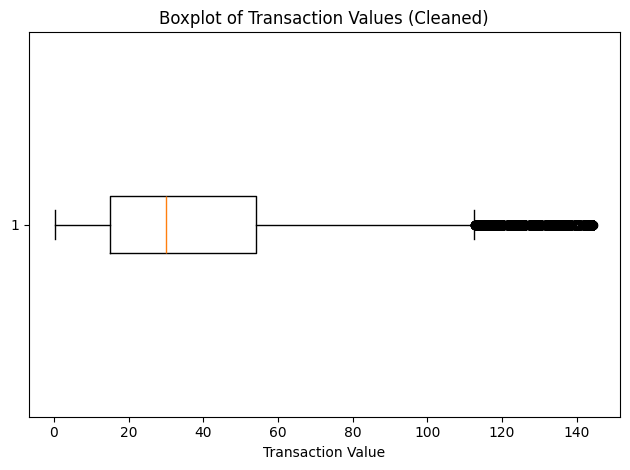

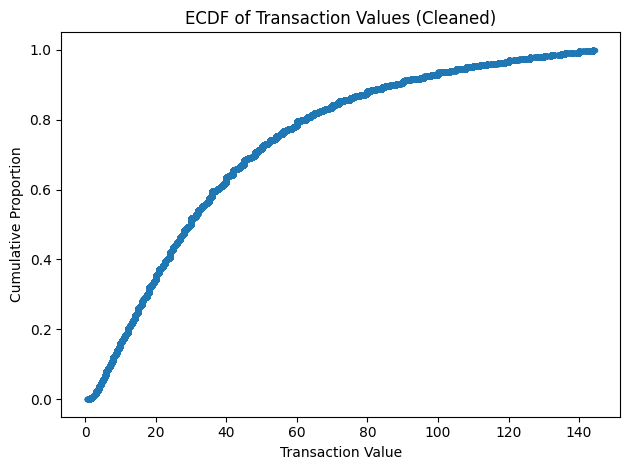

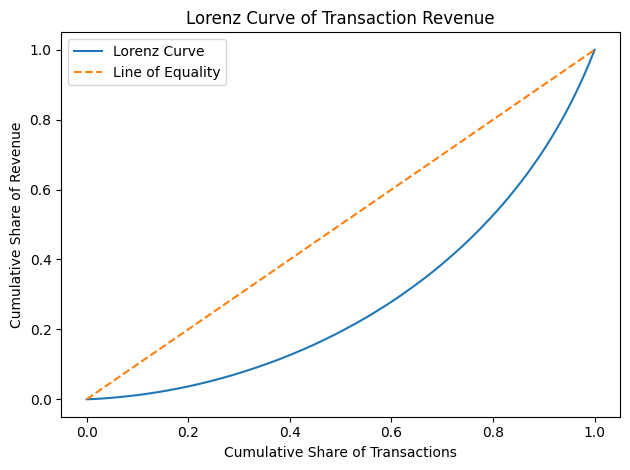

Gini Coefficient of Transaction Revenue: 0.4361


<ipython-input-5-efa65c226393>:73: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  gini = 1 - 2 * np.trapz(cum_prop_vals, cum_prop_trans)


In [ ]:
import numpy as np

# 2. Compute transaction-level sums
transaction_totals = df.groupby('Transaction ID')['Total'].sum().reset_index(name='TransactionSum')

# 3. IQR bounds for outlier removal
Q1 = transaction_totals['TransactionSum'].quantile(0.25)
Q3 = transaction_totals['TransactionSum'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 4. Filter out outlier transactions
clean_totals = transaction_totals[
    (transaction_totals['TransactionSum'] >= lower_bound) &
    (transaction_totals['TransactionSum'] <= upper_bound)
]['TransactionSum']

# 5. Skewness & Kurtosis
skewness = clean_totals.skew()
kurtosis = clean_totals.kurtosis()
stats_df = pd.DataFrame({
    'Metric': ['Skewness', 'Kurtosis'],
    'Value': [skewness, kurtosis]
})

# 6. Key Quantiles
quantiles_df = clean_totals.quantile([0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).reset_index()
quantiles_df.columns = ['Quantile', 'TransactionValue']

# Display tables
print("\nSkewness & Kurtosis:")
display(stats_df)

print("Key Quantiles:")
display(quantiles_df)

# 7. Boxplot
plt.figure()
plt.boxplot(clean_totals, vert=False)
plt.title('Boxplot of Transaction Values (Cleaned)')
plt.xlabel('Transaction Value')
plt.tight_layout()
plt.show()

# 8. ECDF
sorted_vals = np.sort(clean_totals)
ecdf = np.arange(1, len(sorted_vals) + 1) / len(sorted_vals)
plt.figure()
plt.plot(sorted_vals, ecdf, marker='.', linestyle='none')
plt.title('ECDF of Transaction Values (Cleaned)')
plt.xlabel('Transaction Value')
plt.ylabel('Cumulative Proportion')
plt.tight_layout()
plt.show()

# 9. Lorenz curve & Gini
cum_vals = sorted_vals.cumsum()
cum_prop_vals = cum_vals / cum_vals[-1]
cum_prop_trans = ecdf

plt.figure()
plt.plot(cum_prop_trans, cum_prop_vals, label='Lorenz Curve')
plt.plot([0,1], [0,1], linestyle='--', label='Line of Equality')
plt.title('Lorenz Curve of Transaction Revenue')
plt.xlabel('Cumulative Share of Transactions')
plt.ylabel('Cumulative Share of Revenue')
plt.legend()
plt.tight_layout()
plt.show()

# Gini coefficient
gini = 1 - 2 * np.trapz(cum_prop_vals, cum_prop_trans)
print(f"Gini Coefficient of Transaction Revenue: {gini:.4f}")

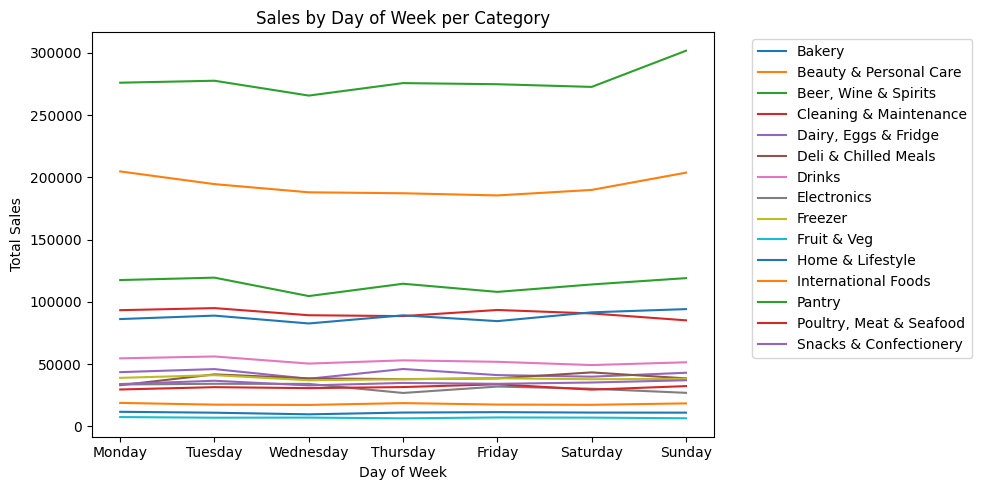

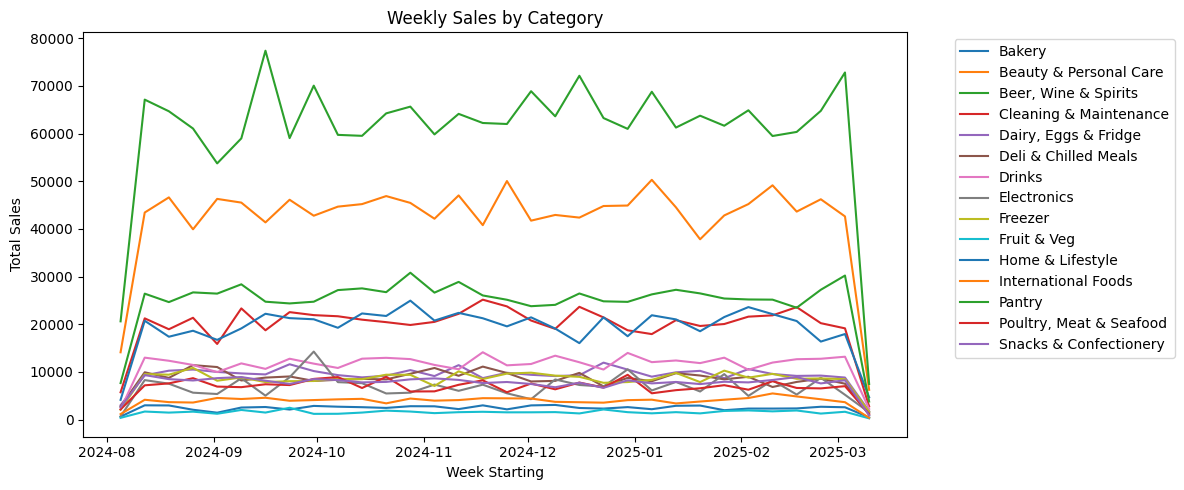

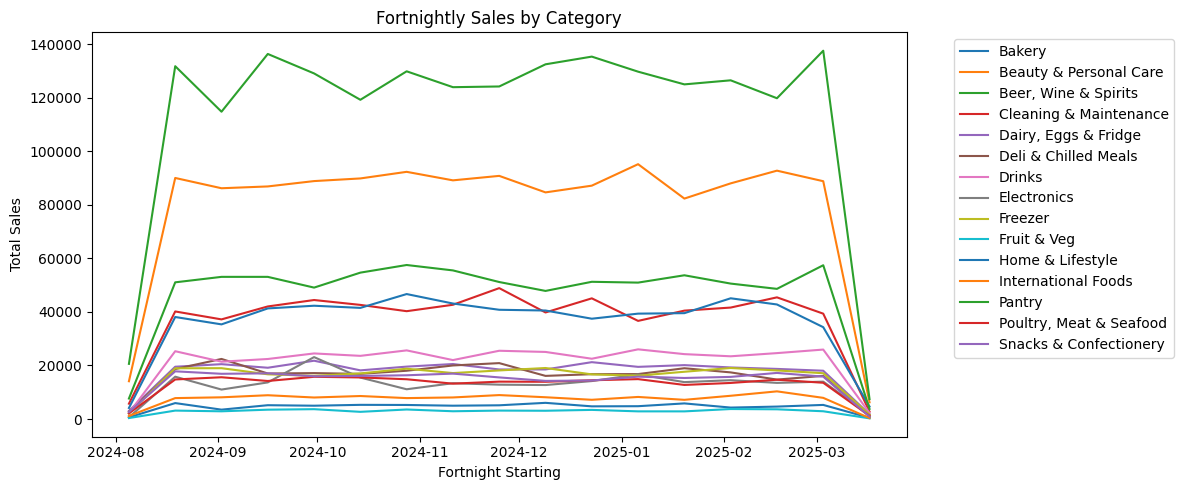

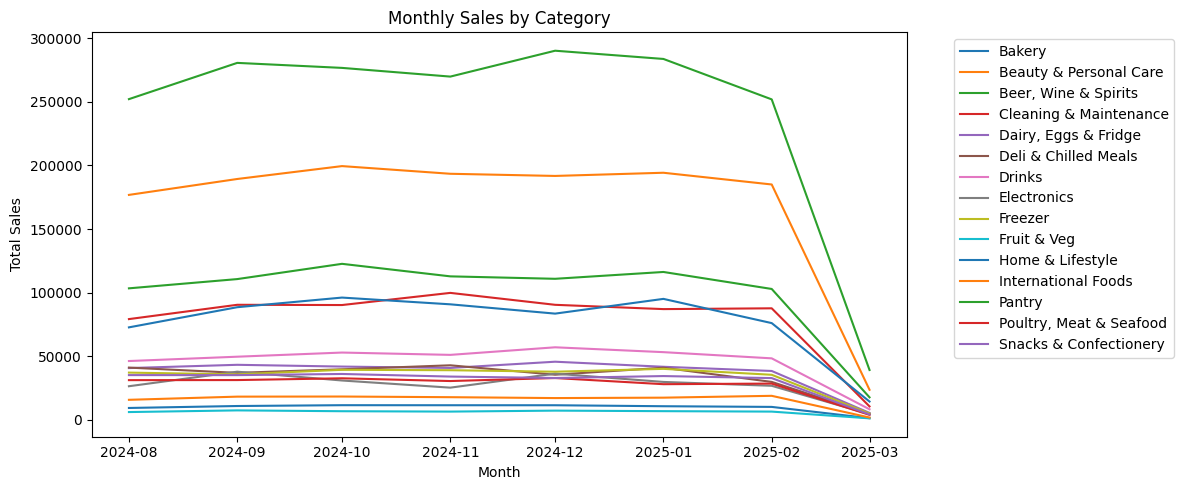

In [ ]:
# 1. Sales by Day of Week
dow_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dow_sales = (
    df
    .groupby([df['PurchaseDate'].dt.day_name(), 'Category'])['TransactionValue']
    .sum()
    .unstack()
    .reindex(dow_order)
)

plt.figure(figsize=(10,5))
for cat in dow_sales.columns:
    plt.plot(dow_sales.index, dow_sales[cat], label=cat)
plt.title('Sales by Day of Week per Category')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 2. Weekly Sales by Category using pivot_table + Grouper
weekly_sales = pd.pivot_table(
    df,
    index=pd.Grouper(key='PurchaseDate', freq='W-MON'),
    columns='Category',
    values='TransactionValue',
    aggfunc='sum'
)

plt.figure(figsize=(12,5))
for cat in weekly_sales.columns:
    plt.plot(weekly_sales.index, weekly_sales[cat], label=cat)
plt.title('Weekly Sales by Category')
plt.xlabel('Week Starting')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 3. Fortnightly Sales by Category (2-week periods)
fort_sales = pd.pivot_table(
    df,
    index=pd.Grouper(key='PurchaseDate', freq='2W-MON'),
    columns='Category',
    values='TransactionValue',
    aggfunc='sum'
)

plt.figure(figsize=(12,5))
for cat in fort_sales.columns:
    plt.plot(fort_sales.index, fort_sales[cat], label=cat)
plt.title('Fortnightly Sales by Category')
plt.xlabel('Fortnight Starting')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Monthly Sales by Category
monthly_sales = pd.pivot_table(
    df,
    index=pd.Grouper(key='PurchaseDate', freq='MS'),
    columns='Category',
    values='TransactionValue',
    aggfunc='sum'
)

plt.figure(figsize=(12,5))
for cat in monthly_sales.columns:
    plt.plot(monthly_sales.index, monthly_sales[cat], label=cat)
plt.title('Monthly Sales by Category')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:

# 2. Compute metrics per category
per_category = (
    df.groupby('Category')
      .agg(
          TransactionCount=('Transaction ID', 'nunique'),
          LineItemCount=('Item ID', 'count'),
          TotalSales=('Total', 'sum')
      )
      .reset_index()
      .sort_values('TotalSales', ascending=False)
)

# 3. Print the full table
print("Sales Metrics per Category:\n")
print(per_category.to_string(index=False))

# 4. Print only the top 10 by TotalSales
print("\nTop 10 Categories by TotalSales:\n")
print(per_category.head(10).to_string(index=False))

Sales Metrics per Category:

               Category  TransactionCount  LineItemCount  TotalSales
   Beer, Wine & Spirits              8860           8860  1943973.00
 Beauty & Personal Care             17334          17334  1353581.94
                 Pantry             26430          26430   797172.62
 Cleaning & Maintenance             10306          10306   635436.14
       Home & Lifestyle              8825           8825   617246.66
                 Drinks              8082           8082   366807.08
   Dairy, Eggs & Fridge              8066           8066   298055.75
   Deli & Chilled Meals              4662           4662   271772.87
                Freezer              5951           5951   269621.24
 Snacks & Confectionery              8645           8645   244856.98
Poultry, Meat & Seafood              2634           2634   219071.88
            Electronics              1267           1267   217978.50
    International Foods              4849           4849   125522.44
     

In [ ]:
# Compute metrics per category
per_category = (
    df.groupby('Category')
      .agg(
          TransactionCount=('Transaction ID', 'nunique'),
          LineItemCount=('Item ID', 'count'),
          TotalSales=('Total', 'sum')
      )
      .reset_index()
)

# Sort by LineItemCount descending
per_category_sorted = per_category.sort_values(by='LineItemCount', ascending=False)

# Print full table sorted by LineItemCount
print("Sales Metrics per Category (sorted by LineItemCount):\n")
print(per_category_sorted.to_string(index=False))

Sales Metrics per Category (sorted by LineItemCount):

               Category  TransactionCount  LineItemCount  TotalSales
                 Pantry             26430          26430   797172.62
 Beauty & Personal Care             17334          17334  1353581.94
 Cleaning & Maintenance             10306          10306   635436.14
   Beer, Wine & Spirits              8860           8860  1943973.00
       Home & Lifestyle              8825           8825   617246.66
 Snacks & Confectionery              8645           8645   244856.98
                 Drinks              8082           8082   366807.08
   Dairy, Eggs & Fridge              8066           8066   298055.75
                Freezer              5951           5951   269621.24
    International Foods              4849           4849   125522.44
   Deli & Chilled Meals              4662           4662   271772.87
Poultry, Meat & Seafood              2634           2634   219071.88
                 Bakery              2373       

In [ ]:
# 2. Compute the metrics you actually want
per_category = (
    df.groupby('Category')
      .agg(
          TransactionCount=('Transaction ID', 'nunique'),
          UnitsSold        =('Quantity',       'sum'),
          TotalSales       =('Total',          'sum')
      )
      .reset_index()
      .sort_values('TotalSales', ascending=False)
)

# 3. Print the full table
print("Sales Metrics per Category:\n")
print(per_category.to_string(index=False))

# 4. Print the top 10 by TotalSales
print("\nTop 10 Categories by TotalSales:\n")
print(per_category.head(10).to_string(index=False))

Sales Metrics per Category:

               Category  TransactionCount  UnitsSold  TotalSales
   Beer, Wine & Spirits              8860      48657  1943973.00
 Beauty & Personal Care             17334      94851  1353581.94
                 Pantry             26430     144323   797172.62
 Cleaning & Maintenance             10306      56767   635436.14
       Home & Lifestyle              8825      48377   617246.66
                 Drinks              8082      44175   366807.08
   Dairy, Eggs & Fridge              8066      44253   298055.75
   Deli & Chilled Meals              4662      25599   271772.87
                Freezer              5951      33019   269621.24
 Snacks & Confectionery              8645      47703   244856.98
Poultry, Meat & Seafood              2634      14612   219071.88
            Electronics              1267       7012   217978.50
    International Foods              4849      26923   125522.44
                 Bakery              2373      13190    77018

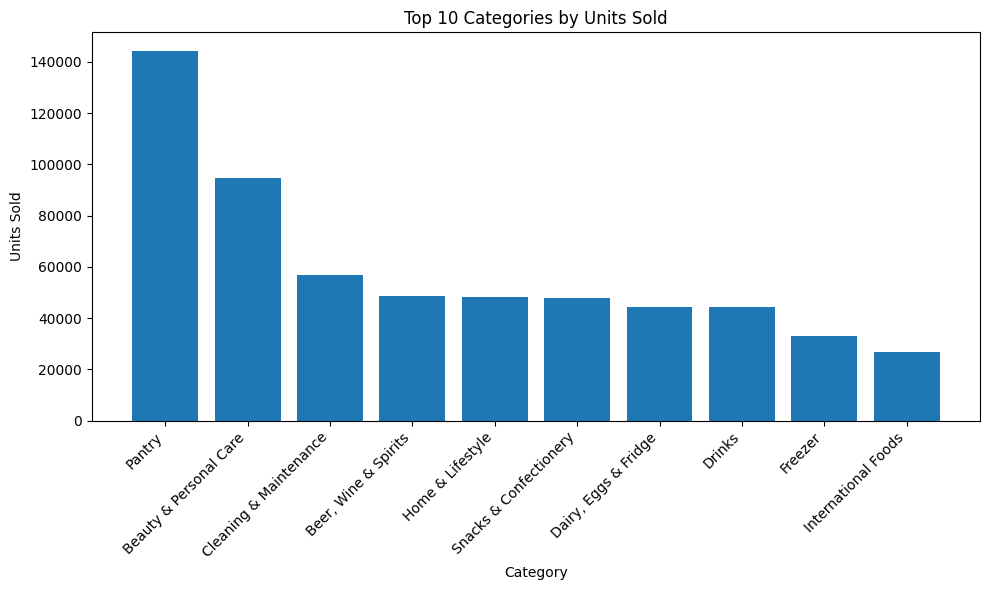

In [ ]:
# Compute units sold per category
units_sold = (
    df.groupby('Category')
      .agg(UnitsSold=('Quantity', 'sum'))
      .sort_values('UnitsSold', ascending=False)
)

# Plot top 10 categories by units sold
top10_units = units_sold.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top10_units.index, top10_units['UnitsSold'])
plt.title('Top 10 Categories by Units Sold')
plt.xlabel('Category')
plt.ylabel('Units Sold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


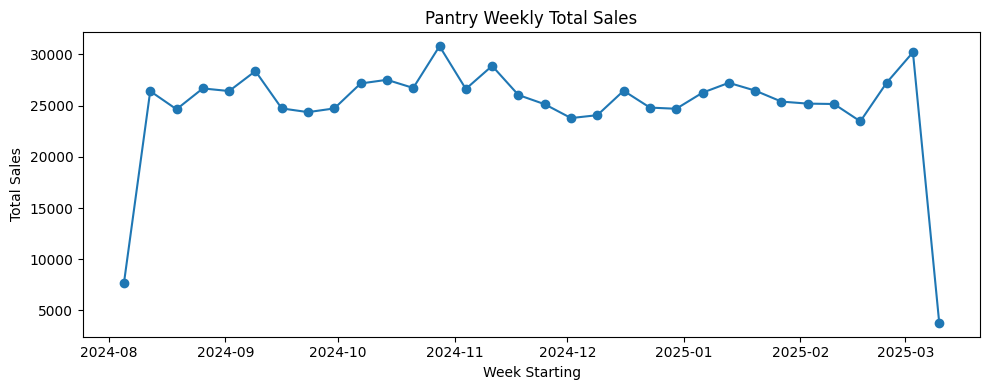

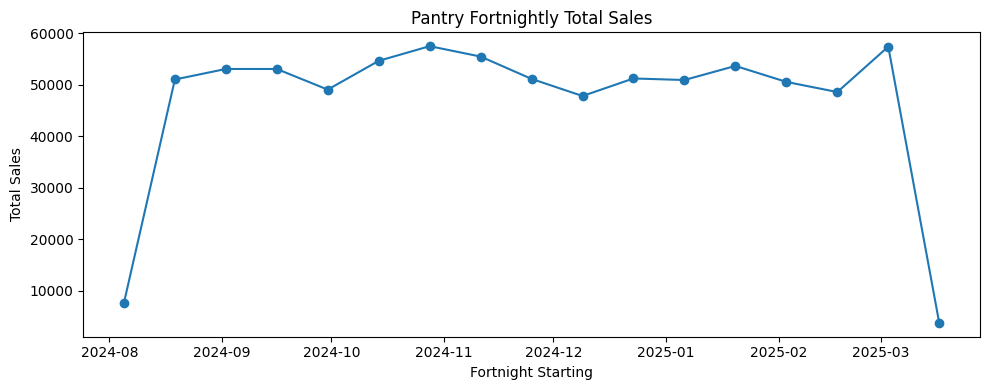

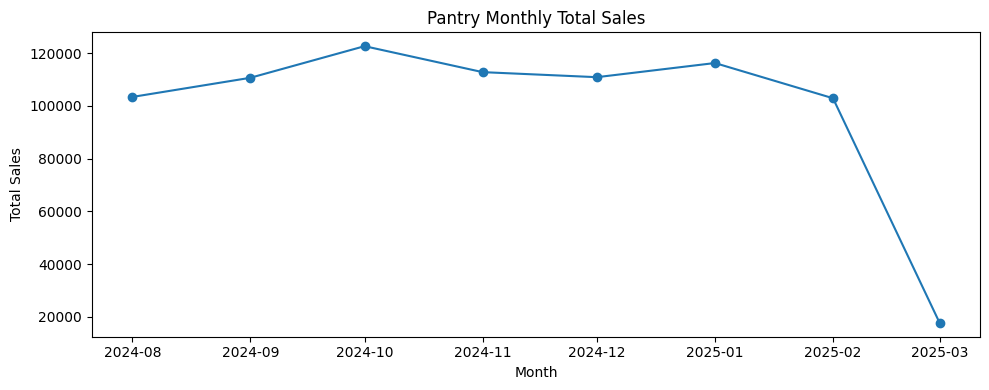

In [ ]:
# Filter for Pantry category
pantry = df[df['Category'] == 'Pantry'].copy()
pantry['TransactionValue'] = pantry['Total']

# 1. Weekly Total Sales for Pantry
weekly = pantry.resample('W-MON', on='PurchaseDate')['TransactionValue'].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(weekly['PurchaseDate'], weekly['TransactionValue'], marker='o')
plt.title('Pantry Weekly Total Sales')
plt.xlabel('Week Starting')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# 2. Fortnightly Total Sales for Pantry
fortnightly = pantry.resample('2W-MON', on='PurchaseDate')['TransactionValue'].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(fortnightly['PurchaseDate'], fortnightly['TransactionValue'], marker='o')
plt.title('Pantry Fortnightly Total Sales')
plt.xlabel('Fortnight Starting')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# 3. Monthly Total Sales for Pantry
monthly = pantry.resample('MS', on='PurchaseDate')['TransactionValue'].sum().reset_index()

plt.figure(figsize=(10,4))
plt.plot(monthly['PurchaseDate'], monthly['TransactionValue'], marker='o')
plt.title('Pantry Monthly Total Sales')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

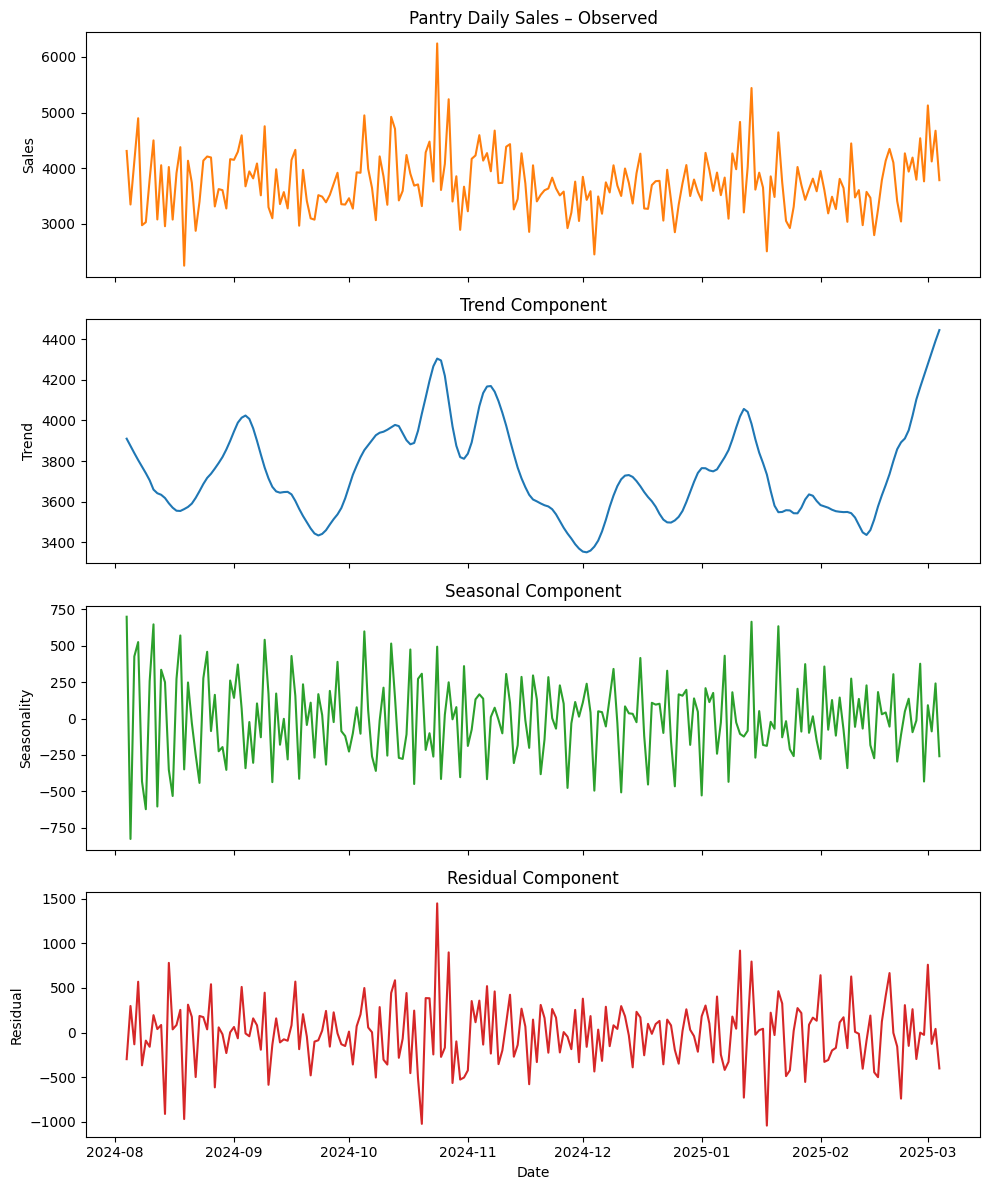

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

#

# 2. Filter to Pantry
pantry = df[df['Category'] == 'Pantry'].copy()

# 3. Build a gap-free daily series of total sales
pantry_daily = (
    pantry
    .resample('D', on='PurchaseDate')['Total']
    .sum()
    .asfreq('D', fill_value=0)
)

# 4. Run STL (weekly seasonality = 7 days)
stl = STL(pantry_daily, period=7)
res = stl.fit()

# 5. Plot everything
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axes[0].plot(pantry_daily.index, pantry_daily, color='tab:orange')
axes[0].set(title='Pantry Daily Sales – Observed', ylabel='Sales')

axes[1].plot(res.trend.index, res.trend, color='tab:blue')
axes[1].set(title='Trend Component', ylabel='Trend')

axes[2].plot(res.seasonal.index, res.seasonal, color='tab:green')
axes[2].set(title='Seasonal Component', ylabel='Seasonality')

axes[3].plot(res.resid.index, res.resid, color='tab:red')
axes[3].set(title='Residual Component', xlabel='Date', ylabel='Residual')

plt.tight_layout()
plt.show()

Autocorrelation at 7-day lag: 0.161

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.747
Date:                Fri, 16 May 2025   Prob (F-statistic):              0.177
Time:                        21:42:47   Log-Likelihood:                -1642.3
No. Observations:                 213   AIC:                             3291.
Df Residuals:                     210   BIC:                             3301.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       374

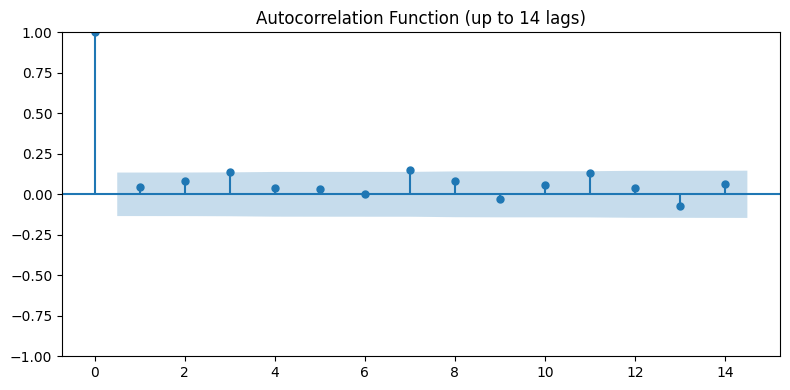

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Prepare pantry daily series
pantry_daily = (
    df[df['Category'] == 'Pantry']
    .resample('D', on='PurchaseDate')['Total']
    .sum()
    .asfreq('D', fill_value=0)
)

# 1. Autocorrelation at lag 7
lag7 = pantry_daily.autocorr(lag=7)
print(f'Autocorrelation at 7-day lag: {lag7:.3f}\n')

# 2. Fourier regression for weekly seasonality
t = np.arange(len(pantry_daily))
X = pd.DataFrame({
    'sin7': np.sin(2 * np.pi * t / 7),
    'cos7': np.cos(2 * np.pi * t / 7)
}, index=pantry_daily.index)
X = sm.add_constant(X)
model = sm.OLS(pantry_daily.values, X).fit()
print(model.summary())

# 3. Plot ACF
plt.figure(figsize=(8, 4))
plot_acf(pantry_daily, lags=14, ax=plt.gca())
plt.title('Autocorrelation Function (up to 14 lags)')
plt.tight_layout()
plt.show()

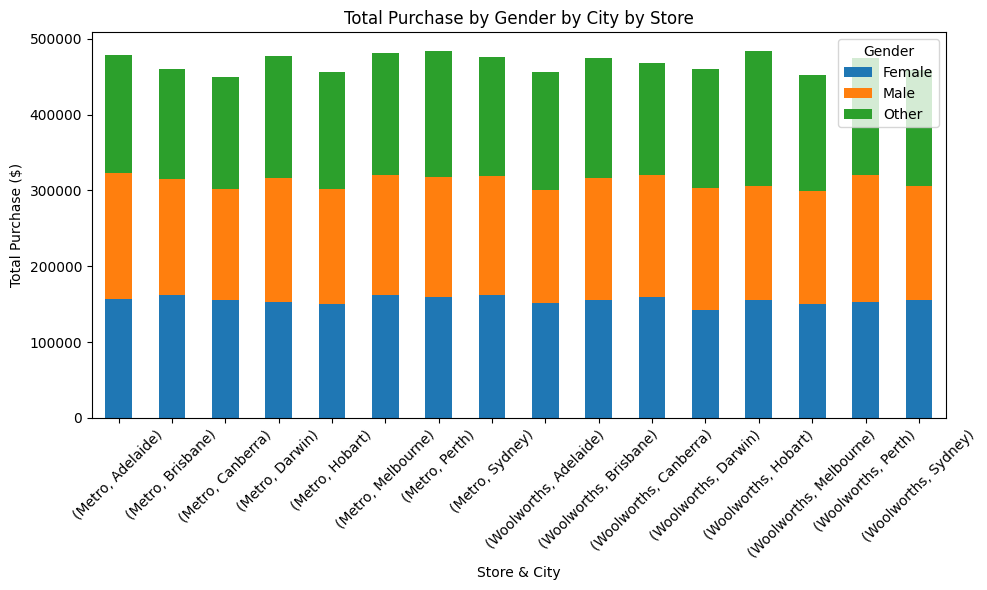

In [ ]:
#df['PurchaseDate'] = pd.to_datetime(df['Purchase Date'])

df['TransactionValue'] = df['Total']

# Group data by Store, Location, and Gender

grouped = df.groupby(['Store Name', 'Location', 'Gender'])['TransactionValue'].sum().reset_index()


pivot_df = grouped.pivot_table(index=['Store Name', 'Location'], columns='Gender', values='TransactionValue', fill_value=0)

# Plot

pivot_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Total Purchase by Gender by City by Store')

plt.xlabel('Store & City')

plt.ylabel('Total Purchase ($)')

plt.xticks(rotation=45)

plt.legend(title='Gender')

plt.tight_layout()

plt.show()


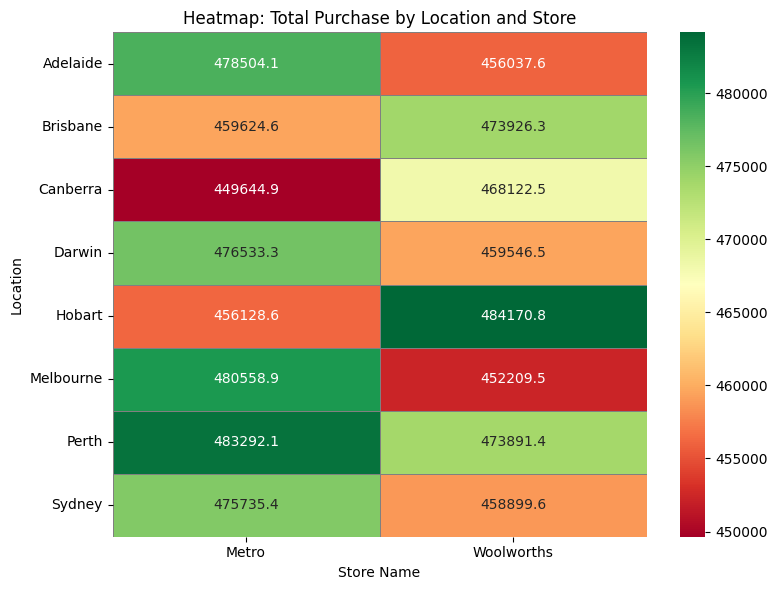

In [ ]:
import seaborn as sns

grouped = df.groupby(['Location', 'Store Name'])['TransactionValue'].sum().reset_index()

#Pivot to create matrix format
pivot_df = grouped.pivot(index='Location', columns='Store Name', values='TransactionValue').fillna(0)

#Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_df, annot=True, fmt=".1f", cmap="RdYlGn", linewidths=0.5, linecolor='gray')
plt.title('Heatmap: Total Purchase by Location and Store')
plt.xlabel('Store Name')
plt.ylabel('Location')
plt.tight_layout()
plt.show()

<ipython-input-16-3196b96acb5f>:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=grouped, x='Location', y='Count', hue='Payment Type', ci=None, dodge=True)


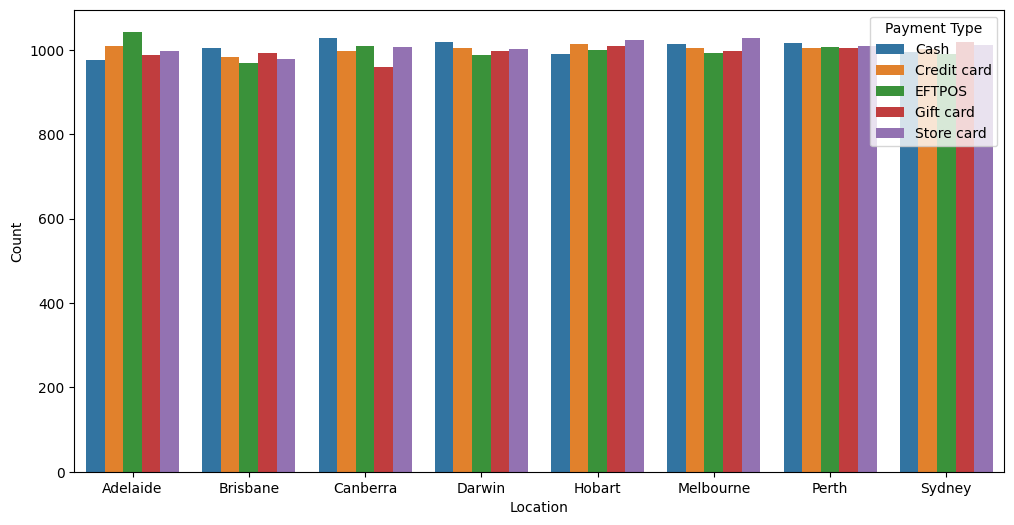

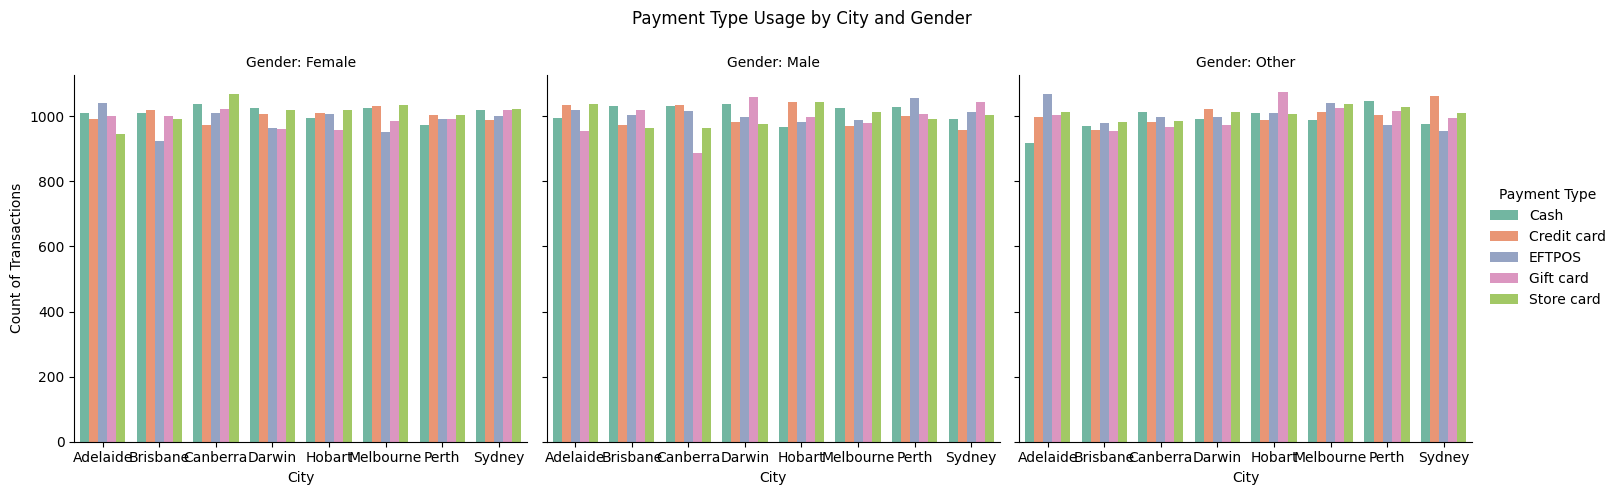

In [ ]:
# Payment Type Breakdown by City and Gender


# Group and count

grouped = df.groupby(['Location', 'Gender', 'Payment Type']).size().reset_index(name='Count')

plt.figure(figsize=(12, 6))

sns.barplot(data=grouped, x='Location', y='Count', hue='Payment Type', ci=None, dodge=True)

# Split by gender using FacetGrid

g = sns.catplot(

    data=grouped,

    kind='bar',

    x='Location',

    y='Count',

    hue='Payment Type',

    col='Gender',

    height=5,

    aspect=1,

    palette='Set2'

)

g.fig.subplots_adjust(top=0.85)

g.fig.suptitle('Payment Type Usage by City and Gender')

g.set_axis_labels("City", "Count of Transactions")

g.set_titles("Gender: {col_name}")

plt.show()


In [ ]:
grouped

Location  Gender Payment Type  Count
0    Adelaide  Female         Cash   1011
1    Adelaide  Female  Credit card    993
2    Adelaide  Female       EFTPOS   1040
3    Adelaide  Female    Gift card   1000
4    Adelaide  Female   Store card    944
..        ...     ...          ...    ...
115    Sydney   Other         Cash    977
116    Sydney   Other  Credit card   1062
117    Sydney   Other       EFTPOS    954
118    Sydney   Other    Gift card    994
119    Sydney   Other   Store card   1011

[120 rows x 4 columns]

In [ ]:
import os
import pandas as pd
# Define paths

base_path = '/content/drive/My Drive/Colab Notebooks/supermarket transactional data'

coles_file = os.path.join(base_path, 'customer_transactions_coles.csv')

woolies_file = os.path.join(base_path, 'customer_transactions_woolies.csv')

df_coles = pd.read_csv(coles_file)

df_woolies = pd.read_csv(woolies_file)

# Show sample

print("Coles Sample:")

print(df_coles.head())

print("\nWoolies Sample:")

print(df_woolies.head())


print((df_coles.columns),(df_woolies.columns))

print(set(df_coles.columns) == set(df_woolies.columns))


Coles Sample:
      TransactionID CustomerID             DateTime              PatternType  \
0  T1743741247-3058      C1001  2024-10-06T18:59:00  Health-Focused Shopping   
1  T1743741247-3058      C1001  2024-10-06T18:59:00  Health-Focused Shopping   
2  T1743741247-3058      C1001  2024-10-06T18:59:00  Health-Focused Shopping   
3  T1743741247-3058      C1001  2024-10-06T18:59:00  Health-Focused Shopping   
4  T1743741247-3058      C1001  2024-10-06T18:59:00  Health-Focused Shopping   

   TotalQuantity  TotalAmount  ProductCode              Category  \
0             20        150.5      3224092             Household   
1             20        150.5      6316583                Drinks   
2             20        150.5      3899135        Meat & Seafood   
3             20        150.5      1262363  Dairy, Eggs & Fridge   
4             20        150.5      5300861                Frozen   

                                            ItemName  UnitPrice  Quantity  
0  Coles Ultra Conce

In [ ]:
df_coles['Store'] = 'Coles'
df_woolies['Store'] = 'Woolworths'


# Combine
df = pd.concat([df_coles, df_woolies], ignore_index=True)

# Parse datetime
df['DateTime'] = pd.to_datetime(df['DateTime'])

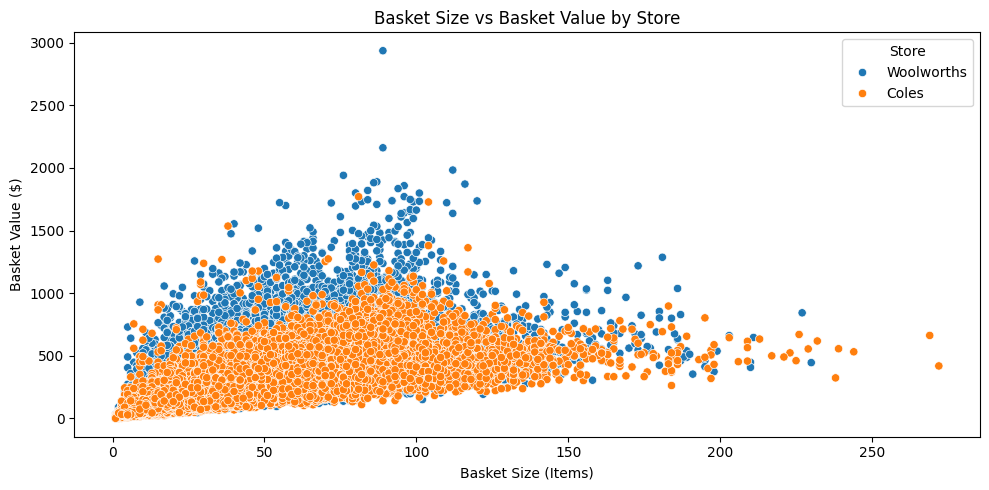

In [ ]:
# 1. Basket Size vs Basket Value by Store

basket_summary = df.groupby(['TransactionID', 'Store']).agg(

    BasketSize=('Quantity', 'sum'),

    BasketValue=('TotalAmount', 'mean')

).reset_index()

plt.figure(figsize=(10, 5))

sns.scatterplot(data=basket_summary, x='BasketSize', y='BasketValue', hue='Store')

plt.title("Basket Size vs Basket Value by Store")

plt.xlabel("Basket Size (Items)")

plt.ylabel("Basket Value ($)")

plt.tight_layout()

plt.show()



In [ ]:
# unique catagoires in each data for "Catagory" column
coles_unique = df_coles['Category'].unique()

woolies_unique = df_woolies['Category'].unique()

print("Coles Unique Categories:", coles_unique)
print("Woolies Unique Categories:", woolies_unique)

Coles Unique Categories: ['Household' 'Drinks' 'Meat & Seafood' 'Dairy, Eggs & Fridge' 'Frozen'
 'Pantry' 'Deli' 'Health & Beauty' 'Bakery' 'Fruit & Vegetables']
Woolies Unique Categories: ['International Foods' 'Pantry' 'Poultry, Meat & Seafood'
 'Beer, Wine & Spirits' 'Bakery' 'Dairy, Eggs & Fridge'
 'Snacks & Confectionery' 'Beauty & Personal Care'
 'Cleaning & Maintenance' 'Fruit & Veg' 'Drinks' 'Deli & Chilled Meals'
 'Home & Lifestyle' 'Freezer']


In [ ]:
category_map = {

    'Fruit & Vegetables': 'Fruit & Veg',

    'Fruit & Veg': 'Fruit & Veg',

    'Meat & Seafood': 'Meat & Seafood',

    'Poultry, Meat & Seafood': 'Meat & Seafood',

    'Frozen': 'Frozen',

    'Freezer': 'Frozen',

    'Deli': 'Deli & Meals',

    'Deli & Chilled Meals': 'Deli & Meals',

    'Health & Beauty': 'Beauty & Personal Care',

    'Beauty & Personal Care': 'Beauty & Personal Care',

    'Household': 'Cleaning & Household',

    'Cleaning & Maintenance': 'Cleaning & Household',

}

# Apply mapping

df['StandardCategory'] = df['Category'].replace(category_map)



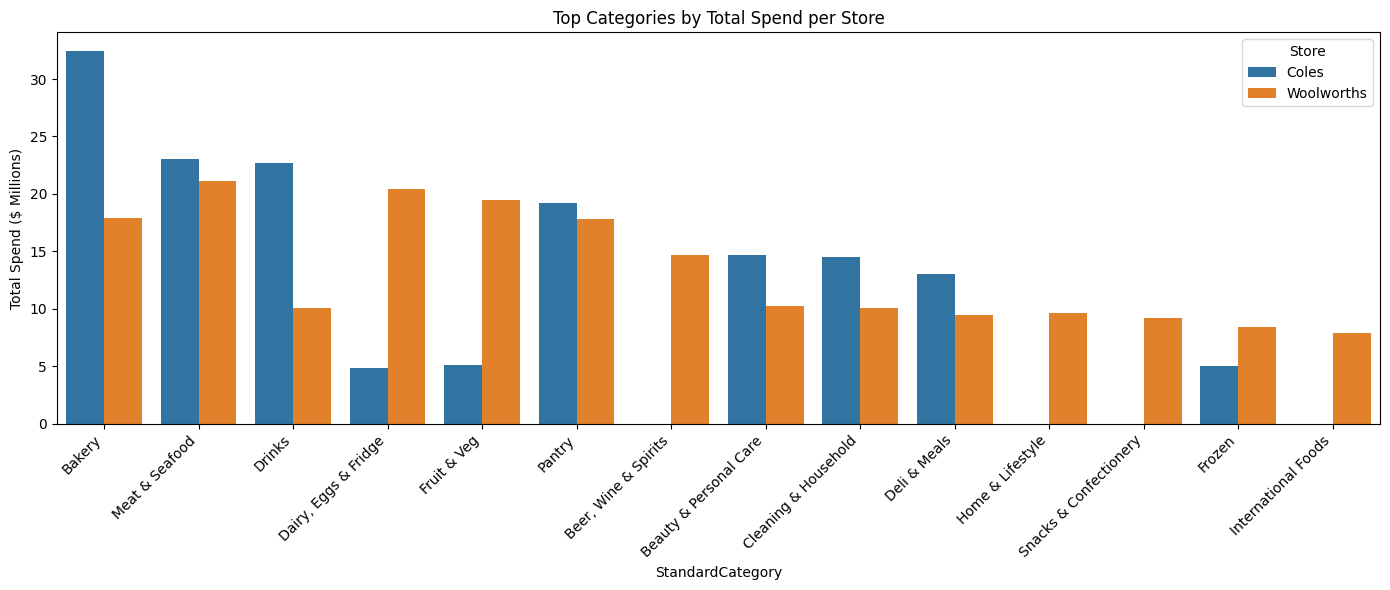

In [ ]:
# 2. Top Categories by Total Spend per Store

top_categories = df.groupby(['Store', 'StandardCategory'])['TotalAmount'].sum().reset_index()

top_categories['TotalAmount'] = top_categories['TotalAmount'] / 1e6

top_categories_sorted = top_categories.sort_values(by='TotalAmount', ascending=False)

plt.figure(figsize=(14, 6))

sns.barplot(data=top_categories_sorted, x='StandardCategory', y='TotalAmount', hue='Store')

plt.title("Top Categories by Total Spend per Store")

plt.xlabel("StandardCategory")

plt.ylabel("Total Spend ($ Millions)")

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()



In [ ]:
coles_patterns = df[df['Store'] == 'Coles']['PatternType'].dropna().unique()

woolies_patterns = df[df['Store'] == 'Woolworths']['PatternType'].dropna().unique()

{

    "Coles Pattern Types": sorted(coles_patterns),

    "Woolworths Pattern Types": sorted(woolies_patterns)

}


{'Coles Pattern Types': ['Health-Focused Shopping',
  'Home Essentials',
  'International Cuisine',
  'Party Supplies',
  'Quick Meal Shopping',
  'Weekly Grocery Shopping'],
 'Woolworths Pattern Types': ['Health-Focused Shopping',
  'Home Essentials',
  'International Cuisine',
  'Party Supplies',
  'Quick Meal Shopping',
  'Weekly Grocery Shopping']}

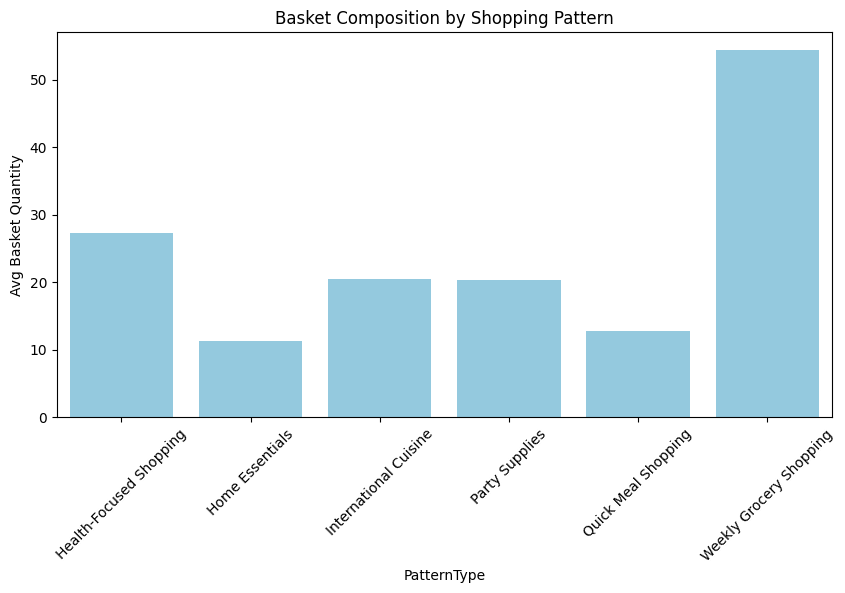

In [ ]:

# Basket Composition Patterns (Avg TotalQuantity & TotalAmount by Pattern)

composition = df.groupby('PatternType').agg({'TotalQuantity': 'mean', 'TotalAmount': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))

sns.barplot(data=composition, x='PatternType', y='TotalQuantity', ax=ax1, color='skyblue')

ax1.set_ylabel("Avg Basket Quantity")

ax1.set_title("Basket Composition by Shopping Pattern")

ax1.tick_params(axis='x', rotation=45)


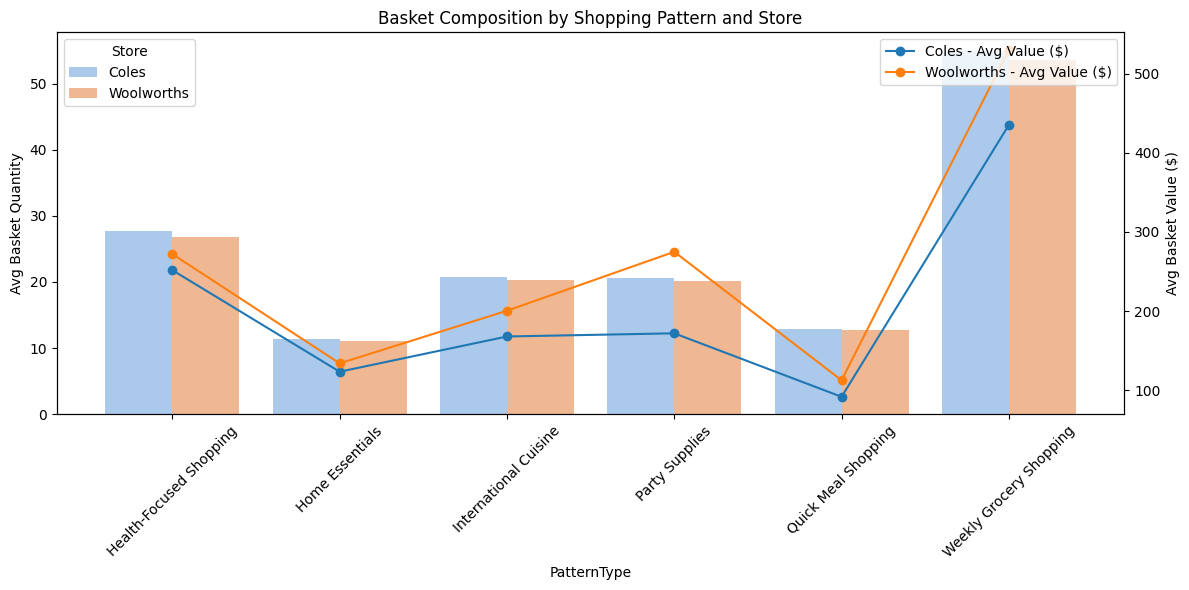

In [ ]:


#Aggregate by Store and PatternType

composition = df.groupby(['Store', 'PatternType']).agg({

    'TotalQuantity': 'mean',

    'TotalAmount': 'mean'

}).reset_index()

#Plot side-by-side bar for Quantity, with line overlay for Value

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for Avg Quantity

sns.barplot(

    data=composition,

    x='PatternType',

    y='TotalQuantity',

    hue='Store',

    ax=ax1,

    palette='pastel'

)

ax1.set_ylabel("Avg Basket Quantity")

ax1.set_title("Basket Composition by Shopping Pattern and Store")

ax1.tick_params(axis='x', rotation=45)

#Line plot overlay for Avg Value

ax2 = ax1.twinx()

for store in composition['Store'].unique():

    store_data = composition[composition['Store'] == store]

    ax2.plot(

        store_data['PatternType'],

        store_data['TotalAmount'],

        marker='o',

        label=f'{store} - Avg Value ($)'

    )

ax2.set_ylabel("Avg Basket Value ($)")

ax2.legend(loc='upper right')

plt.tight_layout()

plt.show()



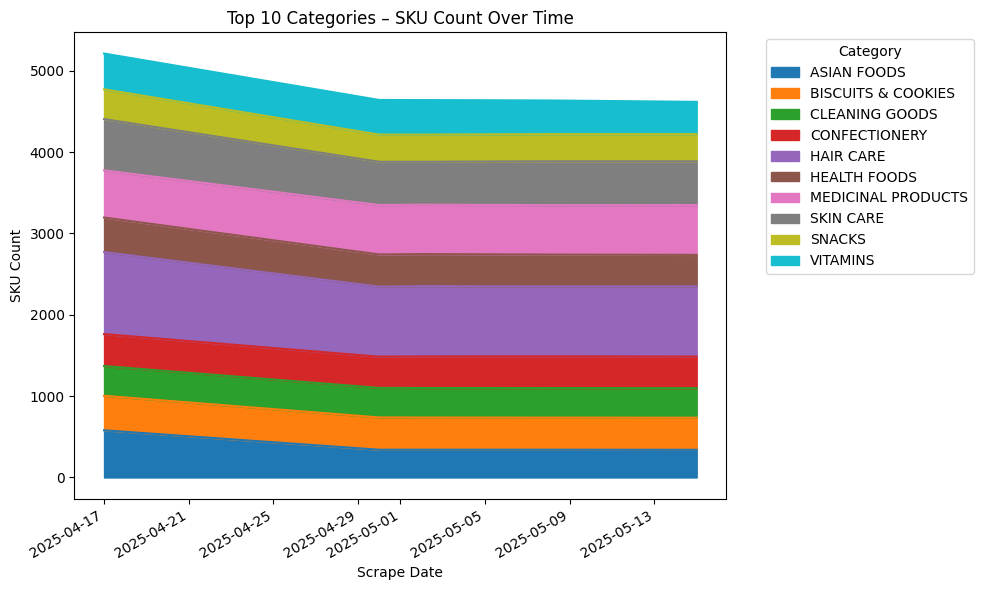

In [ ]:
# --- Top-10 Categories by SKU Count Over Time -------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1.  Load the merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2.  Ensure scrape_date is datetime (it was added when you merged)
df['scrape_date'] = pd.to_datetime(df['scrape_date'])

# 3.  Drop duplicate SKUs per date (one row per product_code per scrape)
df_unique = df.drop_duplicates(subset=['scrape_date', 'product_code'])

# 4.  Count SKUs per category per scrape date
cat_counts = (
    df_unique.groupby(['scrape_date', 'category'])
             .size()
             .reset_index(name='sku_count')
)

# 5.  Identify the overall top-10 categories (by total SKU count)
top10_cats = (
    cat_counts.groupby('category')['sku_count']
              .sum()
              .sort_values(ascending=False)
              .head(10)
              .index.tolist()
)

# 6.  Keep only those top-10 and pivot for plotting
top10_counts = (
    cat_counts[cat_counts['category'].isin(top10_cats)]
    .pivot(index='scrape_date', columns='category', values='sku_count')
    .fillna(0)
    .sort_index()
)

# 7.  Plot
plt.figure(figsize=(10,6))
top10_counts.plot.area(ax=plt.gca())  # one stacked area chart
plt.title("Top 10 Categories – SKU Count Over Time")
plt.xlabel("Scrape Date")
plt.ylabel("SKU Count")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


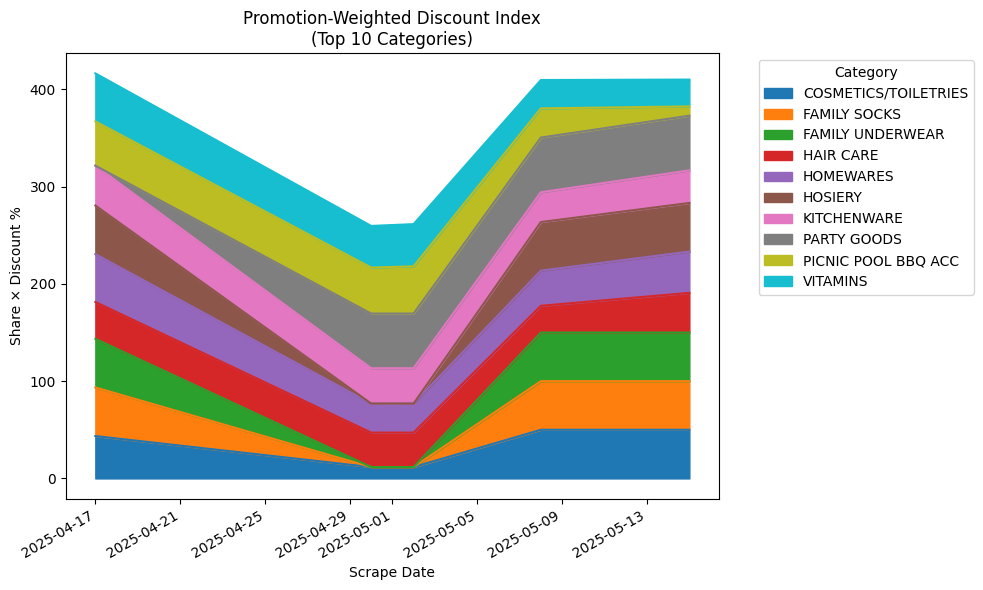

category  pw_discount_index
0            PARTY GOODS          56.250000
1       FAMILY UNDERWEAR          50.000000
2                HOSIERY          50.000000
3           FAMILY SOCKS          50.000000
4               VITAMINS          38.487008
5              HOMEWARES          37.500308
6    PICNIC POOL BBQ ACC          36.171345
7            KITCHENWARE          35.559487
8              HAIR CARE          35.434212
9   COSMETICS/TOILETRIES          33.377270
10      BOXED CHOCOLATES          32.909504
11                EASTER          30.797918
12           DISHWASHING          27.999890
13               LAUNDRY          26.437589
14       SEASONAL EVENTS          24.227730
15            ELECTRICAL          23.605058
16             SKIN CARE          23.556302
17     SOAPS & BODY WASH          22.869727
18  HOUSEHOLD APPLIANCES          22.720322
19     CONVENIENCE MEALS          22.199597

In [ ]:
# --- Promotion-Weighted Discount Index --------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1.  Load data
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2.  Prep columns
df['scrape_date']  = pd.to_datetime(df['scrape_date'])
df['item_price']   = pd.to_numeric(df['item_price'], errors='coerce')
df['best_price']   = pd.to_numeric(df['best_price'], errors='coerce')

# Keep valid rows
df = df[(df['item_price'] > 0) & (df['best_price'] > 0)]

# 3.  Flags & discount %
df['on_promo']     = df['promo_text'].notna() | df['special_text'].notna()
df['discount_pct'] = np.where(
    df['on_promo'],
    (df['item_price'] - df['best_price']) / df['item_price'] * 100,
    0.0
)

# 4.  Category-date aggregates
cat_daily = (
    df.groupby(['scrape_date', 'category'])
      .agg(
          promo_share      = ('on_promo', 'mean'),              # 0-1
          avg_discount_pct = ('discount_pct', 'mean')           # already zero for non-promo rows
      )
      .reset_index()
)

# 5.  Weighted index  (share × depth)
cat_daily['pw_discount_index'] = cat_daily['promo_share'] * cat_daily['avg_discount_pct']

# 6.  Identify overall top-10 categories by average index
top10_cats = (
    cat_daily.groupby('category')['pw_discount_index']
             .mean()
             .sort_values(ascending=False)
             .head(10)
             .index.tolist()
)

# 7.  Pivot for plotting
pivot_top10 = (
    cat_daily[cat_daily['category'].isin(top10_cats)]
      .pivot(index='scrape_date', columns='category', values='pw_discount_index')
      .sort_index()
)

# 8.  Plot – stacked area
plt.figure(figsize=(10,6))
pivot_top10.plot.area(ax=plt.gca())
plt.title("Promotion-Weighted Discount Index\n(Top 10 Categories)")
plt.xlabel("Scrape Date")
plt.ylabel("Share × Discount %")
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

# 9.  Optional table of overall averages
overall_index = (
    cat_daily.groupby('category')['pw_discount_index']
             .mean()
             .sort_values(ascending=False)
             .reset_index()
)

display(overall_index.head(20))  # top-20 for quick view


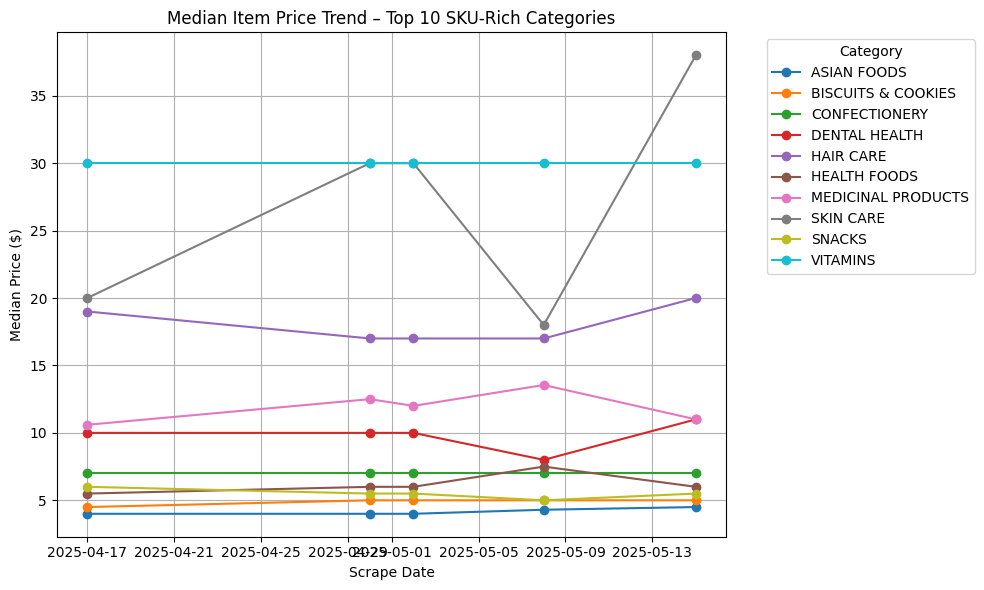

first_price  last_price  pct_change
category                                               
SKIN CARE                  20.0        38.0   90.000000
ASIAN FOODS                 4.0         4.5   12.500000
BISCUITS & COOKIES          4.5         5.0   11.111111
DENTAL HEALTH              10.0        11.0   10.000000
HEALTH FOODS                5.5         6.0    9.090909
HAIR CARE                  19.0        20.0    5.263158
MEDICINAL PRODUCTS         10.6        11.0    3.773585
CONFECTIONERY               7.0         7.0    0.000000
VITAMINS                   30.0        30.0    0.000000
SNACKS                      6.0         5.5   -8.333333

In [ ]:
# --- Category-Level Median Price Trends -------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# 1.  Load the merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2.  Prep columns
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df['item_price']  = pd.to_numeric(df['item_price'], errors='coerce')
df = df[df['item_price'] > 0]

# 3.  Compute median price by category per scrape
cat_price = (
    df.groupby(['scrape_date', 'category'])['item_price']
      .median()
      .reset_index(name='median_price')
)

# 4.  Pick the 10 categories with the highest overall SKU count
top10_cats = (
    df.groupby('category')['product_code']
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index.tolist()
)

trend_df = (
    cat_price[cat_price['category'].isin(top10_cats)]
      .pivot(index='scrape_date', columns='category', values='median_price')
      .sort_index()
)

# 5.  Plot
plt.figure(figsize=(10,6))
for col in trend_df.columns:
    plt.plot(trend_df.index, trend_df[col], marker='o', label=col)

plt.title("Median Item Price Trend – Top 10 SKU-Rich Categories")
plt.xlabel("Scrape Date")
plt.ylabel("Median Price ($)")
plt.legend(title="Category", bbox_to_anchor=(1.05,1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# 6.  Optional table – latest vs. first price & % change
summary = (
    trend_df.apply(
        lambda s: pd.Series({
            'first_price': s.iloc[0],
            'last_price' : s.iloc[-1],
            'pct_change' : (s.iloc[-1] / s.iloc[0] - 1) * 100
        }),
        axis=0              # operate on each column (=category)
    )
    .T                       # transpose so categories are rows
    .sort_values('pct_change', ascending=False)
)

display(summary)


basket_cost  price_index
scrape_date                          
2025-04-17        100.60   100.000000
2025-04-30        111.50   110.834990
2025-05-02        111.00   110.337972
2025-05-08        102.35   101.739563
2025-05-15        121.50   120.775348

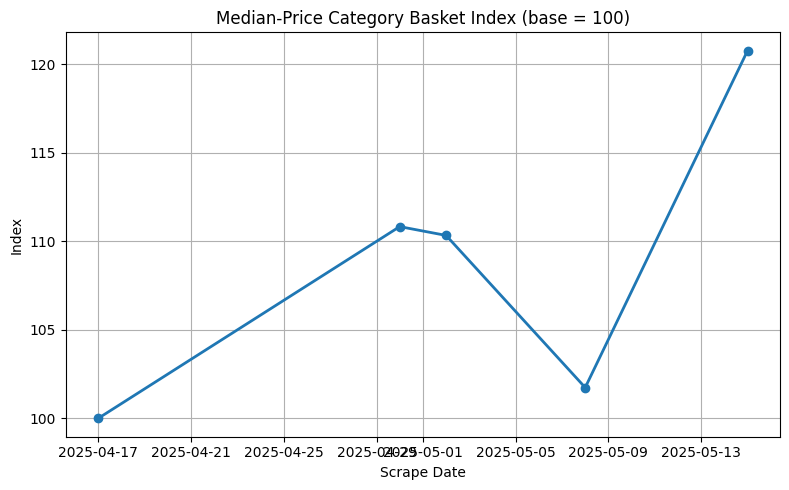

In [ ]:
# --- Median-Price Category Basket -------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# tidy
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df['item_price']  = pd.to_numeric(df['item_price'], errors='coerce')
df = df[df['item_price'] > 0]

# top 8 categories by unique SKU count (reuse your earlier logic if you like)
top_cats = (
    df.groupby('category')['product_code']
      .nunique()
      .sort_values(ascending=False)
      .head(8)
      .index
      .tolist()
)

# median price per category/date
cat_median = (
    df[df['category'].isin(top_cats)]
      .groupby(['scrape_date', 'category'])['item_price']
      .median()
      .unstack()            # rows = date, cols = category
      .sort_index()
      .ffill()              # forward-fill in case a category is missing a scrape
)

# basket cost = sum of category medians
basket_cost = cat_median.sum(axis=1).rename("basket_cost").to_frame()
base = basket_cost.iloc[0, 0]
basket_cost["price_index"] = basket_cost["basket_cost"] / base * 100

display(basket_cost.head())  # quick look

# plot
plt.figure(figsize=(8,5))
plt.plot(basket_cost.index, basket_cost["price_index"], marker="o", linewidth=2)
plt.title("Median-Price Category Basket Index (base = 100)")
plt.xlabel("Scrape Date")
plt.ylabel("Index")
plt.grid(True)
plt.tight_layout()
plt.show()


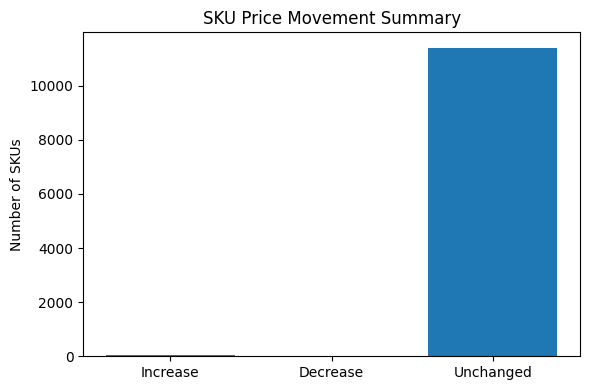

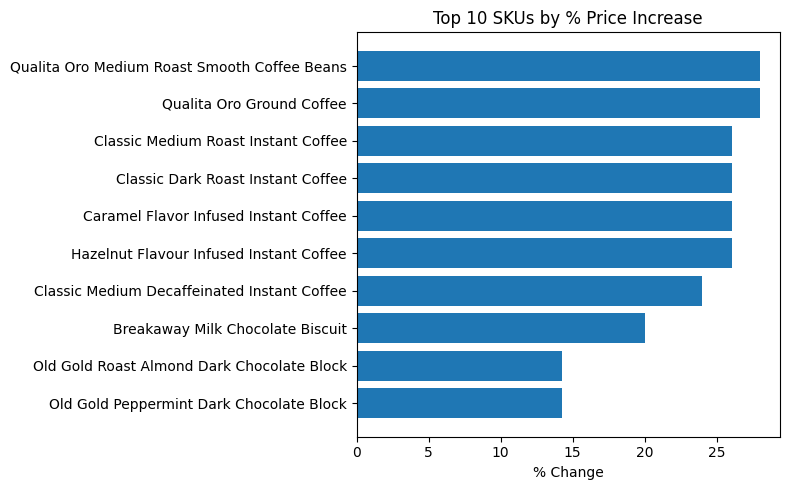

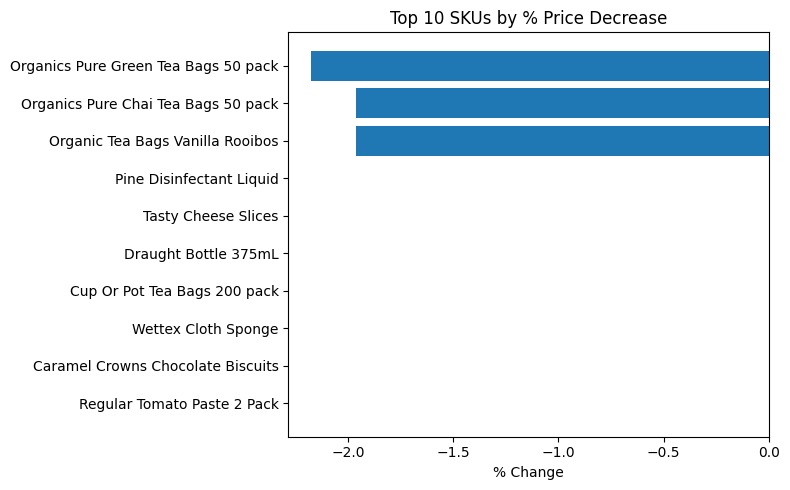

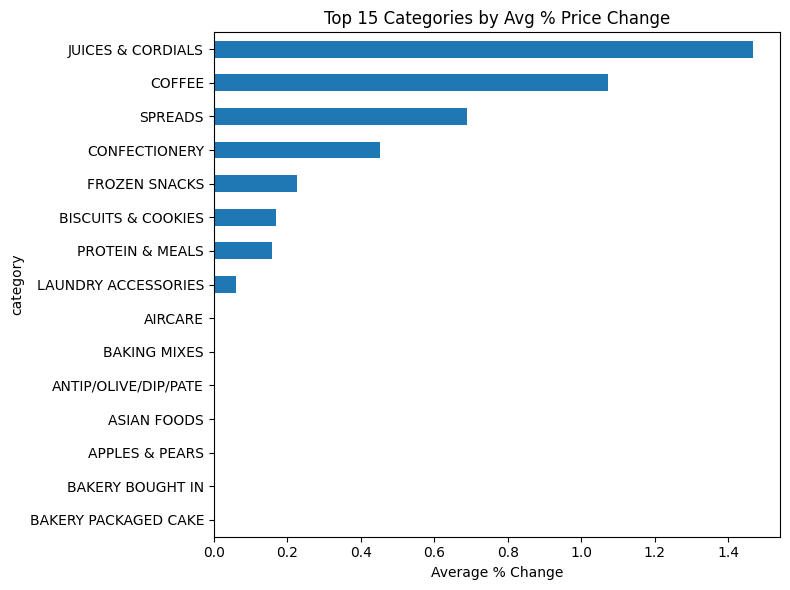

Movement Counts: {'Increase': np.int64(50), 'Decrease': np.int64(3), 'Unchanged': np.int64(11404)}


product_code  first_price  last_price        category  \
0          8090          8.0         8.0  CLEANING GOODS   
1          8578         11.0        11.0    CHEESE DAIRY   
2         15950         63.0        63.0            BEER   
3         24304          6.3         6.3             TEA   
4         25012          4.7         4.7  CLEANING GOODS   

                      item_name  abs_change  pct_change  
0      Pine Disinfectant Liquid         0.0         0.0  
1           Tasty Cheese Slices         0.0         0.0  
2          Draught Bottle 375mL         0.0         0.0  
3  Cup Or Pot Tea Bags 200 pack         0.0         0.0  
4           Wettex Cloth Sponge         0.0         0.0

In [ ]:
# --- Price Movement Analysis -----------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Ensure proper types
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df['item_price']  = pd.to_numeric(df['item_price'], errors='coerce')
df = df[df['item_price'] > 0]

# 3. Sort and compute first/last price per SKU
df_sorted = df.sort_values(['product_code', 'scrape_date'])
price_summary = (
    df_sorted.groupby('product_code')
    .agg(
        first_price=('item_price', 'first'),
        last_price=('item_price', 'last'),
        category=('category', 'first'),
        item_name=('item_name', 'first')
    )
    .reset_index()
)

# 4. Calculate changes
price_summary['abs_change'] = price_summary['last_price'] - price_summary['first_price']
price_summary['pct_change'] = (price_summary['abs_change'] / price_summary['first_price']) * 100

# 5. Summary counts
counts = {
    'Increase':  (price_summary['pct_change']  > 0).sum(),
    'Decrease':  (price_summary['pct_change']  < 0).sum(),
    'Unchanged': (price_summary['pct_change'] == 0).sum()
}

# 6. Top movers
top_up   = price_summary.nlargest(10, 'pct_change')
top_down = price_summary.nsmallest(10, 'pct_change')

# 7. Category average change
cat_avg = (
    price_summary.groupby('category')['pct_change']
    .mean()
    .sort_values(ascending=False)
)

# --- Visualizations ---

# A. Movement counts
plt.figure(figsize=(6,4))
plt.bar(counts.keys(), counts.values())
plt.title("SKU Price Movement Summary")
plt.ylabel("Number of SKUs")
plt.tight_layout()
plt.show()

# B. Top increases
plt.figure(figsize=(8,5))
plt.barh(top_up['item_name'], top_up['pct_change'])
plt.title("Top 10 SKUs by % Price Increase")
plt.xlabel("% Change")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# C. Top decreases
plt.figure(figsize=(8,5))
plt.barh(top_down['item_name'], top_down['pct_change'])
plt.title("Top 10 SKUs by % Price Decrease")
plt.xlabel("% Change")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# D. Category average % change (top 15)
plt.figure(figsize=(8,6))
cat_avg.head(15).plot.barh()
plt.title("Top 15 Categories by Avg % Price Change")
plt.xlabel("Average % Change")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# --- Display tables for reference ---
print("Movement Counts:", counts)
display(price_summary.head())


Top 15 Categories by Average Discount Depth (%)


category  avg_discount_depth_pct  avg_discount_freq
99            PARTY GOODS               56.250000                1.0
47           FAMILY SOCKS               50.000000                1.0
48       FAMILY UNDERWEAR               50.000000                1.0
67                HOSIERY               50.000000                1.0
141              VITAMINS               49.322082                1.0
37            DISHWASHING               48.192275                1.0
34   COSMETICS/TOILETRIES               46.662358                1.0
85                LAUNDRY               45.532641                1.0
17       BOXED CHOCOLATES               44.004923                1.0
62              HAIR CARE               43.347940                1.0
118             SKIN CARE               41.955010                1.0
105   PICNIC POOL BBQ ACC               40.327350                1.0
83            KITCHENWARE               39.654411                1.0
0                 AIRCARE               39.334558                1.0
35          DENTAL HEALTH               39.009084                1.0


Top 15 Categories by Discount Frequency (%)


category  avg_discount_depth_pct  avg_discount_freq  \
0                AIRCARE               39.334558                1.0   
1   ANTIP/OLIVE/DIP/PATE               18.099909                1.0   
2         APPLES & PEARS               20.431354                1.0   
3            ASIAN FOODS               20.246603                1.0   
4                   AUTO               28.750209                1.0   
5       BAKERY BOUGHT IN               13.913934                1.0   
6   BAKERY PACKAGED CAKE               24.938526                1.0   
7          BAKERY SNACKS               28.325149                1.0   
8           BAKING MIXES               34.352303                1.0   
9   BARS GUM POCKET PACK               30.457924                1.0   
10   BEAUTY/TRIAL TRAVEL               19.620901                1.0   
11                  BEEF               12.969684                1.0   
12                  BEER                9.492013                1.0   
13        BETTER FOR YOU               29.198596                1.0   
14   BH BOUGHT IN EASTER               20.000000                1.0   

    avg_discount_freq_pct  
0                   100.0  
1                   100.0  
2                   100.0  
3                   100.0  
4                   100.0  
5                   100.0  
6                   100.0  
7                   100.0  
8                   100.0  
9                   100.0  
10                  100.0  
11                  100.0  
12                  100.0  
13                  100.0  
14                  100.0

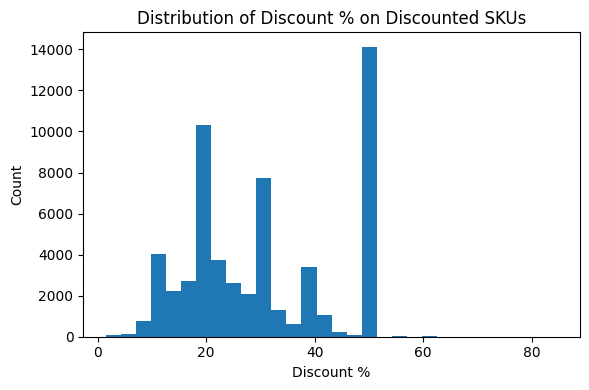

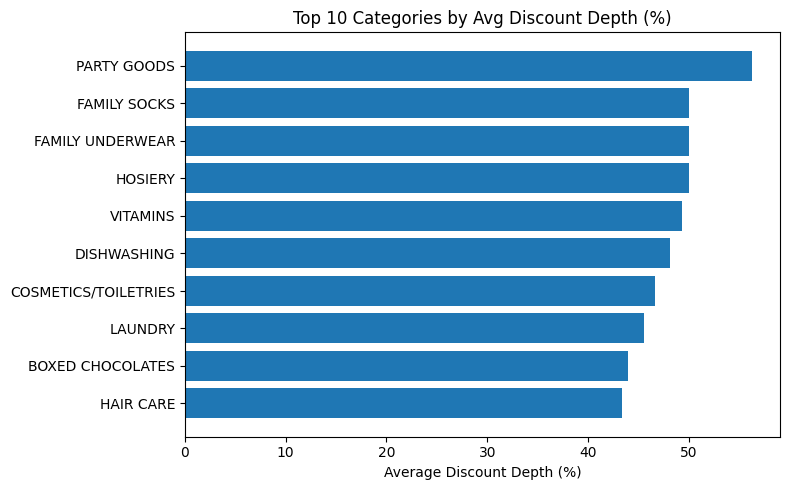

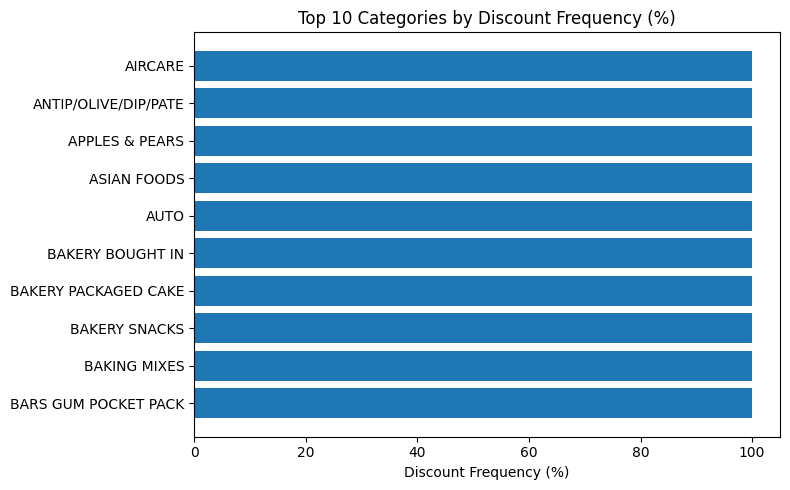

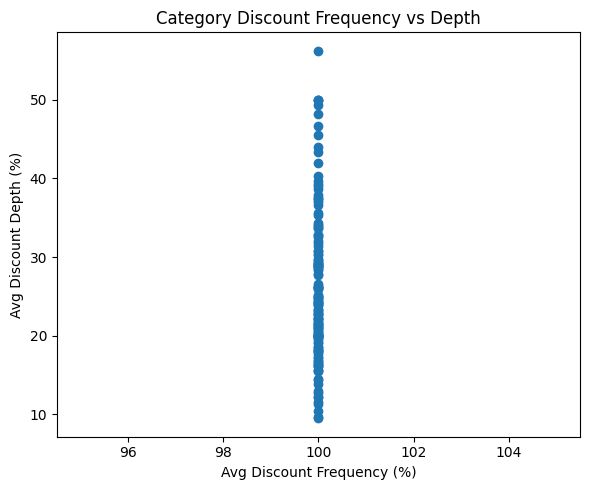

In [ ]:
# --- Discount Depth & Frequency Analysis -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Prepare columns
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df['item_price']  = pd.to_numeric(df['item_price'], errors='coerce')
df['best_price']  = pd.to_numeric(df['best_price'], errors='coerce')
df = df[(df['item_price'] > 0) & (df['best_price'] > 0)]

# 3. Compute discount metrics
df['discount_value'] = df['item_price'] - df['best_price']
df['discount_pct']   = (df['discount_value'] / df['item_price']) * 100
df['on_discount']    = df['discount_value'] > 0

# 4. Aggregate by category & date
cat_daily = (
    df.groupby(['scrape_date','category'])
      .agg(
          avg_depth_pct=('discount_pct', lambda x: x[x > 0].mean()),
          freq=('on_discount','mean')
      )
      .reset_index()
)

# 5. Overall category metrics (average across dates)
cat_overall = (
    cat_daily.groupby('category')
      .agg(
          avg_discount_depth_pct=('avg_depth_pct','mean'),
          avg_discount_freq=('freq','mean')
      )
      .sort_values('avg_discount_freq', ascending=False)
      .reset_index()
)

# 6. Display top 15 categories by depth & frequency
print("Top 15 Categories by Average Discount Depth (%)")
display(cat_overall.nlargest(15, 'avg_discount_depth_pct'))

print("\nTop 15 Categories by Discount Frequency (%)")
# frequency in % terms
cat_overall['avg_discount_freq_pct'] = cat_overall['avg_discount_freq'] * 100
display(cat_overall.nlargest(15, 'avg_discount_freq_pct'))

# 7. Visualisations

# A) Histogram of all discount % values (only positive)
plt.figure(figsize=(6,4))
plt.hist(df.loc[df['on_discount'], 'discount_pct'].dropna(), bins=30)
plt.title('Distribution of Discount % on Discounted SKUs')
plt.xlabel('Discount %')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# B) Bar chart: top 10 categories by depth
top10_depth = cat_overall.nlargest(10, 'avg_discount_depth_pct')
plt.figure(figsize=(8,5))
plt.barh(top10_depth['category'], top10_depth['avg_discount_depth_pct'])
plt.title('Top 10 Categories by Avg Discount Depth (%)')
plt.xlabel('Average Discount Depth (%)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# C) Bar chart: top 10 categories by frequency
top10_freq = cat_overall.nlargest(10, 'avg_discount_freq_pct')
plt.figure(figsize=(8,5))
plt.barh(top10_freq['category'], top10_freq['avg_discount_freq_pct'])
plt.title('Top 10 Categories by Discount Frequency (%)')
plt.xlabel('Discount Frequency (%)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# D) Scatter: frequency vs depth
plt.figure(figsize=(6,5))
plt.scatter(cat_overall['avg_discount_freq_pct'],
            cat_overall['avg_discount_depth_pct'])
plt.title('Category Discount Frequency vs Depth')
plt.xlabel('Avg Discount Frequency (%)')
plt.ylabel('Avg Discount Depth (%)')
plt.tight_layout()
plt.show()


Category Mix – SKU Count per Scrape Date:

category     AIRCARE  ANCIL SERVICES  ANTIP/OLIVE/DIP/PATE  APPLES & PEARS  \
scrape_date                                                                  
2025-04-17       151               6                    40              27   
2025-04-30       146               6                    45              19   
2025-05-02       145               6                    45              19   
2025-05-08       141               5                    45              17   
2025-05-15       137               5                    45              19   

category     ASIAN FOODS  AUTO  AVOCADO & MANGO  BABYWEAR  BAKERY BOUGHT IN  \
scrape_date                                                                   
2025-04-17           580    41                4         7               142   
2025-04-30           341    18                3         0               105   
2025-05-02           341    18                3         0               105   
2025-05-08     

<ipython-input-43-46c0cb892170>:40: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


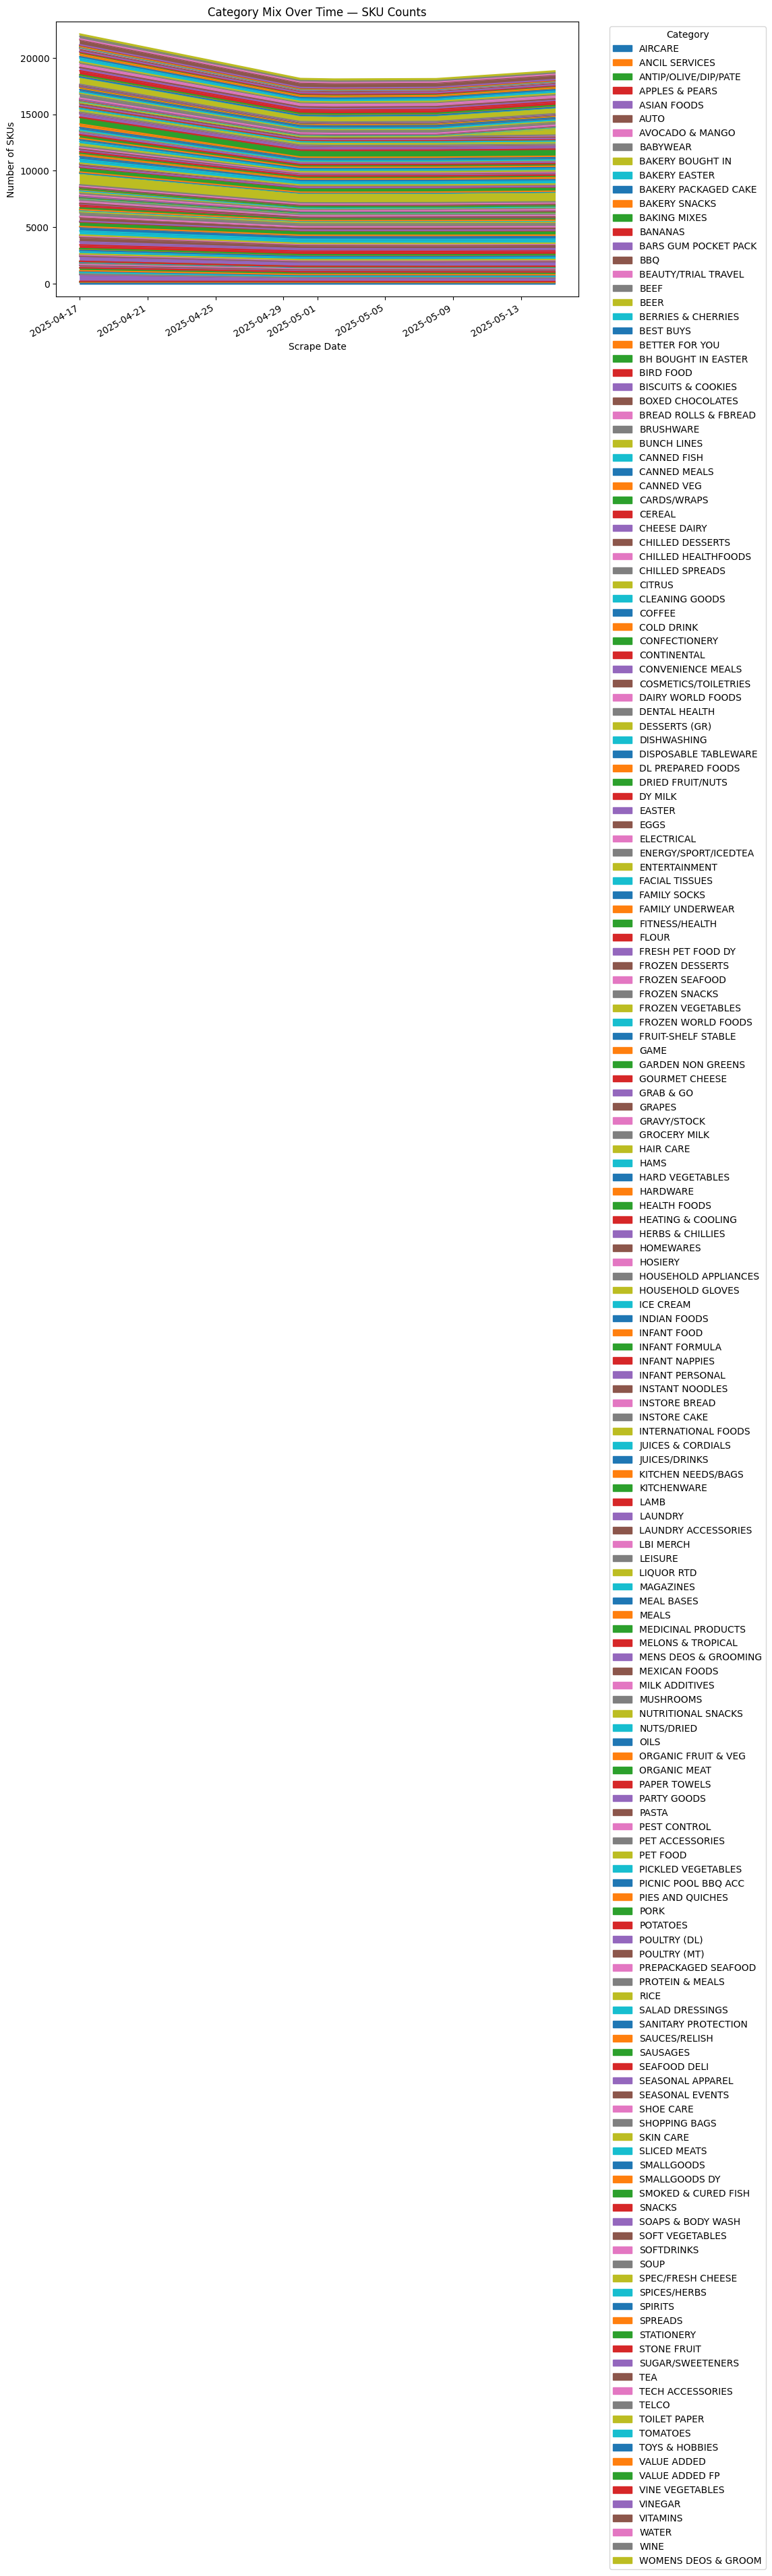

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Parse dates and dedupe per SKU per scrape
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df_unique = df.drop_duplicates(subset=['scrape_date', 'product_code'])

# 3. Count SKUs by category & date
cat_mix = (
    df_unique
      .groupby(['scrape_date', 'category'])
      .size()
      .reset_index(name='sku_count')
)

# 4. Pivot to wide format
pivot_mix = (
    cat_mix
      .pivot(index='scrape_date', columns='category', values='sku_count')
      .fillna(0)
      .astype(int)
      .sort_index()
)

# 5. Display the pivot table
print("Category Mix – SKU Count per Scrape Date:\n")
print(pivot_mix)

# 6. Plot a stacked-area chart
plt.figure(figsize=(10,6))
pivot_mix.plot.area(ax=plt.gca())
plt.title("Category Mix Over Time — SKU Counts")
plt.xlabel("Scrape Date")
plt.ylabel("Number of SKUs")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Top 10 categories by total SKU count across all scrapes:

category     HAIR CARE  MEDICINAL PRODUCTS  SKIN CARE  VITAMINS  \
scrape_date                                                       
2025-04-17        1008                 581        630       440   
2025-04-30         861                 608        532       426   
2025-05-02         864                 607        528       425   
2025-05-08         859                 608        539       414   
2025-05-15         864                 613        538       397   

category     BISCUITS & COOKIES  HEALTH FOODS  CONFECTIONERY  ASIAN FOODS  \
scrape_date                                                                 
2025-04-17                  424           425            393          580   
2025-04-30                  397           396            384          341   
2025-05-02                  396           395            388          341   
2025-05-08                  395           392            391          341   
2025-05-15

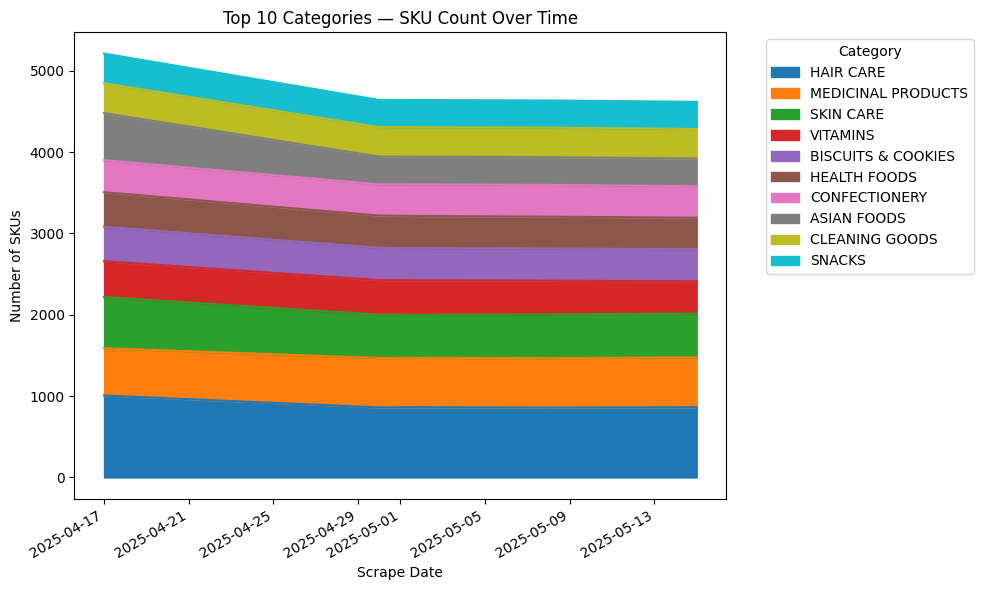

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Parse dates & drop duplicates
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df_unique = df.drop_duplicates(subset=['scrape_date', 'product_code'])

# 3. Count SKUs by category & date
cat_mix = (
    df_unique
      .groupby(['scrape_date', 'category'])
      .size()
      .reset_index(name='sku_count')
)

# 4. Pivot wide
pivot_mix = (
    cat_mix
      .pivot(index='scrape_date', columns='category', values='sku_count')
      .fillna(0)
      .astype(int)
      .sort_index()
)

# 5. Pick top-10 categories by sum of SKUs
top10 = pivot_mix.sum().sort_values(ascending=False).head(10).index.tolist()
pivot_top10 = pivot_mix[top10]

# 6. Print the top-10 table
print("Top 10 categories by total SKU count across all scrapes:\n")
print(pivot_top10)

# 7. Plot stacked-area for top-10 only
plt.figure(figsize=(10,6))
pivot_top10.plot.area(ax=plt.gca())
plt.title("Top 10 Categories — SKU Count Over Time")
plt.xlabel("Scrape Date")
plt.ylabel("Number of SKUs")
plt.legend(title="Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<ipython-input-46-a7135b6566ce>:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.asfreq('D').fillna(method='ffill')  # daily frequency with forward-fill


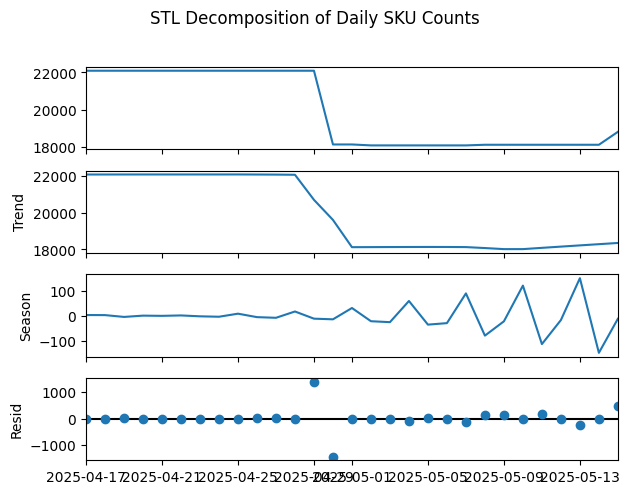

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

# 1. Load merged dataset
data_path = "/content/drive/MyDrive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Prepare time series: count of unique SKUs per scrape_date
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df_unique = df.drop_duplicates(subset=['scrape_date', 'product_code'])
ts = df_unique.groupby('scrape_date').size()
ts = ts.asfreq('D').fillna(method='ffill')  # daily frequency with forward-fill

# 3. STL decomposition (choose period=3 for demo; adjust for your data)
stl = STL(ts, period=3, robust=True)
res = stl.fit()

# 4. Plot the components
res.plot()
plt.suptitle("STL Decomposition of Daily SKU Counts", y=1.02)
plt.tight_layout()
plt.show()


<ipython-input-47-913827142796>:23: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  price_pct = price_wide.pct_change().dropna(how='all')


category              AIRCARE  ANCIL SERVICES  ANTIP/OLIVE/DIP/PATE  \
category                                                              
AIRCARE                   NaN             NaN                   NaN   
ANCIL SERVICES            NaN             NaN                   NaN   
ANTIP/OLIVE/DIP/PATE      NaN             NaN                   NaN   
APPLES & PEARS            NaN             NaN                   NaN   
ASIAN FOODS               NaN             NaN                   NaN   
...                       ...             ...                   ...   
VINEGAR                   NaN             NaN                   NaN   
VITAMINS                  NaN             NaN                   NaN   
WATER                     NaN             NaN                   NaN   
WINE                      NaN             NaN                   NaN   
WOMENS DEOS & GROOM       NaN             NaN                   NaN   

category              APPLES & PEARS  ASIAN FOODS  AUTO  AVOCADO & MANGO  \
category                                                                   
AIRCARE                          NaN          NaN   NaN              NaN   
ANCIL SERVICES                   NaN          NaN   NaN              NaN   
ANTIP/OLIVE/DIP/PATE             NaN          NaN   NaN              NaN   
APPLES & PEARS                   NaN          NaN   NaN              NaN   
ASIAN FOODS                      NaN          NaN   NaN              NaN   
...                              ...          ...   ...              ...   
VINEGAR                          NaN          NaN   NaN              NaN   
VITAMINS                         NaN          NaN   NaN              NaN   
WATER                            NaN          NaN   NaN              NaN   
WINE                             NaN          NaN   NaN              NaN   
WOMENS DEOS & GROOM              NaN          NaN   NaN              NaN   

category              BABYWEAR  BAKERY BOUGHT IN  BAKERY EASTER  ...  \
category                                                         ...   
AIRCARE                    NaN               NaN            NaN  ...   
ANCIL SERVICES             NaN               NaN            NaN  ...   
ANTIP/OLIVE/DIP/PATE       NaN               NaN            NaN  ...   
APPLES & PEARS             NaN               NaN            NaN  ...   
ASIAN FOODS                NaN               NaN            NaN  ...   
...                        ...               ...            ...  ...   
VINEGAR                    NaN               NaN            NaN  ...   
VITAMINS                   NaN               NaN            NaN  ...   
WATER                      NaN               NaN            NaN  ...   
WINE                       NaN               NaN            NaN  ...   
WOMENS DEOS & GROOM        NaN               NaN            NaN  ...   

category              TOMATOES  TOYS & HOBBIES  VALUE ADDED  VALUE ADDED FP  \
category                                                                      
AIRCARE                    NaN             NaN          NaN             NaN   
ANCIL SERVICES             NaN             NaN          NaN             NaN   
ANTIP/OLIVE/DIP/PATE       NaN             NaN          NaN             NaN   
APPLES & PEARS             NaN             NaN          NaN             NaN   
ASIAN FOODS                NaN             NaN          NaN             NaN   
...                        ...             ...          ...             ...   
VINEGAR                    NaN             NaN          NaN             NaN   
VITAMINS                   NaN             NaN          NaN             NaN   
WATER                      NaN             NaN          NaN             NaN   
WINE                       NaN             NaN          NaN             NaN   
WOMENS DEOS & GROOM        NaN             NaN          NaN             NaN   

category              VINE VEGETABLES  VINEGAR  VITAMINS  WATER  WINE  \
category                                         

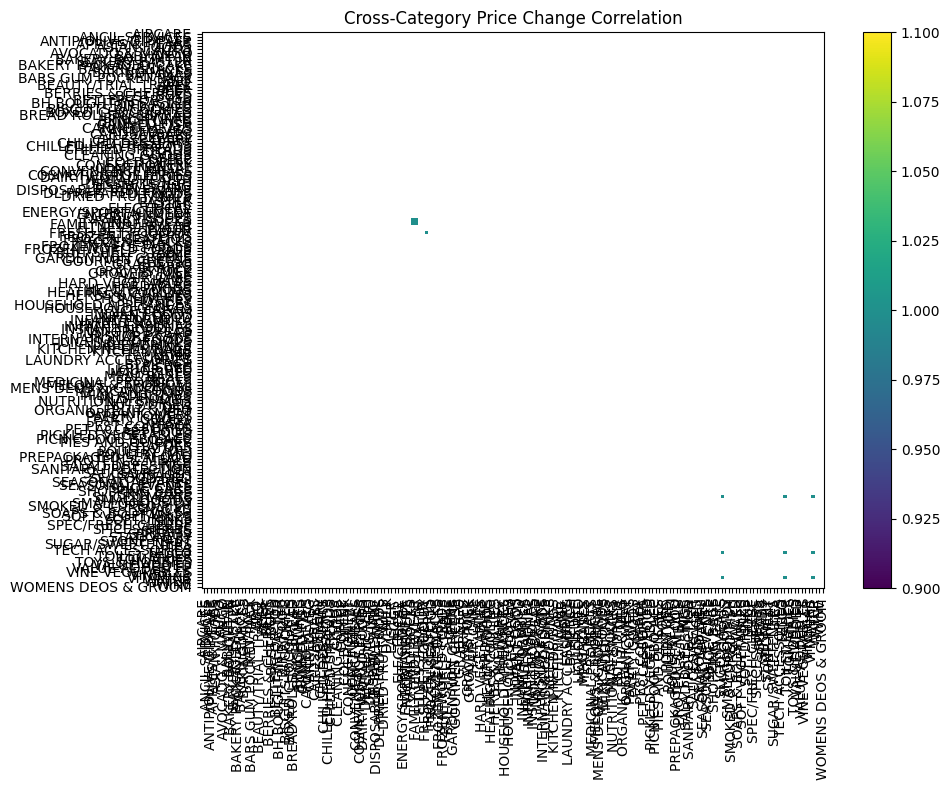

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load merged dataset (adjust path)
data_path = "/content/drive/My Drive/Colab Notebooks/scraped data/Coles_All_Merged.csv"
df = pd.read_csv(data_path)

# 2. Prepare datetime and numeric
df['scrape_date'] = pd.to_datetime(df['scrape_date'])
df['item_price'] = pd.to_numeric(df['item_price'], errors='coerce')

# 3. Median price per category per date
cat_price = (
    df.groupby(['scrape_date', 'category'])['item_price']
      .median()
      .reset_index()
)

# 4. Pivot to wide: date × category
price_wide = cat_price.pivot(index='scrape_date', columns='category', values='item_price')

# 5. Percent-change time series
price_pct = price_wide.pct_change().dropna(how='all')

# 6. Correlation matrix
corr_matrix = price_pct.corr()

# 7. Display table
display(corr_matrix)

# 8. Heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix.values, aspect='auto')
plt.colorbar()
plt.title('Cross-Category Price Change Correlation')
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.index)
plt.tight_layout()
plt.show()
